In [1]:
'''
File name: Project.ipynb
Date created: 01/11/2022
Date last modified: 04/12/2022
Python Version: 3.9.13
'''

'\nFile name: Project.ipynb\nDate created: 01/11/2022\nDate last modified: 04/12/2022\nPython Version: 3.9.13\n'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime #useful for date and time handling
import requests #used for getting data on the internet
from itertools import combinations  #used to create unique pairs from a list
import numpy as np
import plotly.express as px  #for plots with integrated cursor for better visualization
#from pandas_profiling import ProfileReport

DATA_FOLDER = 'MovieSummaries/'

In [3]:
#Create dataframes from the orignal dataset 
moviedata = pd.read_csv(DATA_FOLDER + 'movie.metadata.tsv', sep = '\t', index_col='wiki_id' , header=None, names=('wiki_id','freebase_id','movie_name','release','revenue','runtime','languages','countries','genres'))
charadata = pd.read_csv(DATA_FOLDER + 'character.metadata.tsv', sep = '\t', header=None, names=('wiki_id','freebase_id','release','character_name','actor_dob','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age','freebase_chara_map1','freebase_chara_map2','freebase_chara_map3'))
plots =  pd.read_csv(DATA_FOLDER + 'plot_summaries.txt', sep = '\t', header=None, names=('wiki_id','plot'))

In [4]:
#Set the commom index present in all datasets as wiki_id
charadata.set_index('wiki_id',inplace=True)
plots.set_index('wiki_id',inplace=True)

### Data Exploration

In [5]:
#Filter the three datasets to obtain only movies which have a list of characters and a plot summary
indexes = moviedata.index.intersection(charadata.index)
indexes = plots.index.intersection(indexes)

#Create new filtered dataset using indexes of movies common to the three datasets
moviedata_intersect = moviedata.loc[indexes]
charadata_intersect = charadata.loc[indexes]
plots_intersect = plots.loc[indexes]

In [6]:
print('We had originally the plot summaries of {} movies. After the intersect, we get a total of {} movies from which we have the characters and the plot summaries. Proportion filtered out: {:.2%}.\n'.format(len(plots),len(plots_intersect),1-(len(plots_intersect)/len(plots))))
print('The movie metadata contained originally {} movies. After filtering the dataset, we get {} movies. Proportion filtered out: {:.2%}.\n'.format(len(moviedata),len(moviedata_intersect),1-(len(moviedata_intersect)/len(moviedata))))
print('The character metadata contained originally {} characters. After filtering the dataset, we get {} characters. Proportion filtered out: {:.2%}.'.format(len(charadata),len(charadata_intersect),1-(len(charadata_intersect)/len(charadata))))
print('There are in average {:.2f} characters per movie.'.format(len(charadata_intersect)/len(moviedata_intersect)))

We had originally the plot summaries of 42303 movies. After the intersect, we get a total of 37779 movies from which we have the characters and the plot summaries. Proportion filtered out: 10.69%.

The movie metadata contained originally 81741 movies. After filtering the dataset, we get 37779 movies. Proportion filtered out: 53.78%.

The character metadata contained originally 450669 characters. After filtering the dataset, we get 308485 characters. Proportion filtered out: 31.55%.
There are in average 8.17 characters per movie.


### Profiling

The following cell gives us 3 files (available on github), containing a general overview of the datasets. From these reports, we found irregularities we tackled in the following cells.

In [7]:
#Creates the data profiling files, Can be run only once then commented

'''prof = ProfileReport(moviedata_intersect)
prof.to_file(output_file='moviedata_full.html')
prof = ProfileReport(charadata_intersect)
prof.to_file(output_file='charadata_full.html')
prof = ProfileReport(plots_intersect)
prof.to_file(output_file='plots_full.html')'''

"prof = ProfileReport(moviedata_intersect)\nprof.to_file(output_file='moviedata_full.html')\nprof = ProfileReport(charadata_intersect)\nprof.to_file(output_file='charadata_full.html')\nprof = ProfileReport(plots_intersect)\nprof.to_file(output_file='plots_full.html')"

#### Analysis resultig from profiling : 

Movies dataset :

- 80% of missing values in revenue : *We cannot use this feature*

- Outliers within runtime :  *We are not going to use this feature*

 Character dataset :  
 
- Unknown gender : *These actors play unnamed character in 80% of cases, we could avoid using them when running some analysis*

- Outlier in actor age : *225 values <0 probably due to mistakes, we take these values out to observe distribution*

- Ethnicity : *Hard to use, 75% of missing values*

- Height : *60% of missing values and outliers, anyway not relevant feature in our case*

Code to observe these statements : 

In [8]:
#Look at outliers in movies runtime
print("Number of movies with excessive (>400 min) runtime:", moviedata_intersect['runtime'][moviedata_intersect['runtime']>400].shape[0])
moviedata_intersect[moviedata_intersect['runtime']>400].head(5)


Number of movies with excessive (>400 min) runtime: 20


,freebase_id,movie_name,release,revenue,runtime,languages,countries,genres
wiki_id,,,,,,,,
25930191,/m/0gxf936,Swallow the Sun,2009,NaN,1560.0,{},{},{}
147213,/m/012tj4,Shoah,1985,NaN,544.0,"{""/m/064_8sq"": ""French Language"", ""/m/03hkp"": ...","{""/m/0f8l9c"": ""France""}","{""/m/03g3w"": ""History"", ""/m/082gq"": ""War film""..."
2792417,/m/082yvg,War and Peace,1968-04-28,NaN,401.0,"{""/m/064_8sq"": ""French Language"", ""/m/06b_j"": ...","{""/m/05vz3zq"": ""Soviet Union"", ""/m/06bnz"": ""Ru...","{""/m/03g3w"": ""History"", ""/m/02l7c8"": ""Romance ..."
1060418,/m/042j6p,The 10th Kingdom,2000-02-27,NaN,417.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/015w9s..."
19653659,/m/04myhqx,TASS Is Authorized to Declare,1984,NaN,700.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/05vz3zq"": ""Soviet Union""}","{""/m/03k9fj"": ""Adventure""}"


As one can see, most of the other informations for runtime outliers (expect missing values that will be handled during data filtering) seem to be coherent. As the runtime is not considered for our analysis, we do not need to discard all movies associated to runtime outliers. 

In [9]:
#Look at missing values in actor_gender
print ("Proportion of character without name among actors whose gender is unknown : {0:.2%}".format(charadata_intersect['character_name'][charadata_intersect['actor_gender'].isna()].isna().sum()/len(charadata_intersect['character_name'][charadata_intersect['actor_gender'].isna()])))

Proportion of character without name among actors whose gender is unknown : 81.81%


As we can see, most of non specificied genders arise from unnamed characters, which probably means that these characters are negligable. Thus, we won't take these characters into acount when running analysis on genders.

In [10]:
#Look at outliers in actor age
print("Number of errors in actors age :",len(charadata_intersect[charadata_intersect['actor_age']<0]))
charadata_intersect[charadata_intersect['actor_age']<0].head()

Number of errors in actors age : 225


,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3
wiki_id,,,,,,,,,,,,
22829,/m/05q8n,1965-06-01,The Black Ghoul,1978-07-18,F,NaN,/m/03ts0c,Cheyenne Silver,-13.0,/m/0cbwtz8,/m/0cbwtzc,/m/06616j
4210812,/m/0bq4vz,1910-03-24,Glinda,1992-02-17,M,NaN,NaN,Olive Cox,-81.0,/m/09z696c,/m/022qn6,/m/09z696h
5626726,/m/0dx12p,1936-02-14,NaN,1944-12-09,M,NaN,NaN,Bob O'Connor,-8.0,/m/0k4k1m,NaN,/m/064_gh
7735007,/m/0kvg60,1966,NaN,1996-08-14,M,NaN,NaN,Jack Fletcher,-30.0,/m/0gcmsrc,NaN,/m/07p1ck
6667989,/m/0ggp41,1960-09-22,Khalillah,1989-05-05,F,1.6,NaN,Larissa Wilson,-28.0,/m/063lmhz,/m/063lmj0,/m/02pv8ss


There are 225 outliers with incoherent values for the age, most likely due to errors.

#### Get some of the missing information back

We can see that quite a lot of character's data is missing. We can try to retrieve some of it thanks to the film's, the character's and the actor/actress's freebase ids, respectively the last three columns of the dataframe. We can use the [freebase API](https://developers.google.com/freebase#freebase-wikidata-mappings) which dates back to 2013 and has a mapping between freebase ids and Wikidata using N-Triples RDF. This will allows us to potentially get data back from the corresponding Wikipedia page.

In [11]:
path =  "data/fb2w.nt.gz"
f_w_mapping = pd.read_csv(path, sep='\t', header=None, skiprows=4, names=["Freebase", "W3Consortium", "Wikidata"])
f_w_mapping.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/fb2w.nt.gz'

In [ ]:
# Extracts the freebase id from the url
# Input : url
def extract_freebase_id(url):
    return "/m/" + url[30:-1] #get info between the m. and > symbol in the url

# Extracts the Wikidata id from the url
# Input : url
def extract_wiki_id(url):
    return url[32:-3] #get info between the "entity/" and "> ." symbol in the url

In [ ]:
f_w_id = pd.DataFrame(columns = ["FreeId","WikiQID"])
f_w_id["FreeId"] = f_w_mapping.Freebase.apply(extract_freebase_id)
f_w_id["WikiQID"] = f_w_mapping.Wikidata.apply(extract_wiki_id)

# We don't need the rest of the columns so we drop them 
f_w_id.head()

,FreeId,WikiQID
0,/m/0695j,Q6718
1,/m/05nrg,Q538
2,/m/0jgd,Q414
3,/m/0d_23,Q2537
4,/m/04g7d,Q315


In [ ]:
print("There are {} actor Freebase Ids in the mapping which are also present in the character dataset.".format(charadata_intersect.freebase_chara_map3.isin(f_w_id["FreeId"]).sum()))

There are 202520 actor Freebase Ids in the mapping which are also present in the character dataset.


In [ ]:
charadata_intersect = charadata_intersect.reset_index()
charadata_intersect = charadata_intersect.merge(f_w_id, how="left", left_on="freebase_chara_map3", right_on="FreeId")
charadata_intersect.head()

,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3,FreeId,WikiQID
0,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Natalia Koliakanova,NaN,/m/0gby7pd,NaN,/m/0gby7pj,NaN,NaN
1,23890098,/m/076w2lb,1990-09-07,NaN,1951-04-14,M,NaN,NaN,Pyotr Mamonov,39.0,/m/07lld1w,NaN,/m/06trhc,/m/06trhc,Q2369235
2,23890098,/m/076w2lb,1990-09-07,NaN,1919-10-08,M,NaN,/m/0x67,Hal Singer,70.0,/m/0gc0hbm,NaN,/m/01n4sp6,/m/01n4sp6,Q362776
3,23890098,/m/076w2lb,1990-09-07,NaN,1926-10-26,NaN,NaN,NaN,Vladimir Kashpur,63.0,/m/0gc3tz0,NaN,/m/08087zv,/m/08087zv,Q4218267
4,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Pyotr Zaychenko,NaN,/m/0gcjqgq,NaN,/m/0clzzrg,NaN,NaN


##### Get some of the gender information back

In [ ]:
charadata_intersect.drop(columns=["FreeId"], inplace=True) #no neeed for this redundant column

# get temporary dataframe for data with missing gender and for which we have a Wiki Id
missing_gender = charadata_intersect[(charadata_intersect['actor_gender'].isna() & ~charadata_intersect['WikiQID'].isna())]
map_actor_gender = pd.DataFrame(missing_gender.WikiQID.unique(), columns=["WikiQID"]).dropna()
map_actor_gender["actor_gender"] = None
map_actor_gender.head()

NameError: name 'charadata_intersect' is not defined

In [ ]:
# Get json file from Wikidata using the QID and extract the gender or sex property (noted P21 in Wikidata)
def get_gender_from_json(actor_WikiQID):

    url = "https://www.wikidata.org/wiki/Special:EntityData/" + actor_WikiQID + ".json"
    value = None

    try:
        r = requests.get(url)
        file = r.json()
        value = file['entities'][actor_WikiQID]['claims']['P21'][0]['mainsnak']['datavalue']['value']['id']
    except: 
        pass

    return value

In [ ]:
map_actor_gender.actor_gender = map_actor_gender.WikiQID.apply(get_gender_from_json)

display(map_actor_gender.head(),"The QID of the newly found genders are:",  map_actor_gender['actor_gender'].unique())

,WikiQID,actor_gender
0,Q4218267,Q6581097
1,Q589836,Q6581097
2,Q1134162,Q6581072
3,Q4275805,Q6581097
4,Q2311526,Q6581072


'The QID of the newly found genders are:'

array(['Q6581097', 'Q6581072', None, 'Q44148', 'Q1052281', 'Q43445'],
      dtype=object)

In [ ]:
# Convert the Wikidata QID to actual gender either 'M' for male and 'F' for female and transgender female.
# The meaning of the QID is taken from the Wikidata webpage of the sex or gender property of Wikipedia entities (https://www.wikidata.org/wiki/Property:P21)
def convert_QID(QID):
    if (QID == 'Q6581097') or (QID == 'Q44148'):
        return 'M'
    elif (QID == 'Q6581072') or (QID == 'Q43445') or (QID == 'Q1052281'):
        return 'F'

    return None

In [ ]:
map_actor_gender.actor_gender = map_actor_gender.actor_gender.apply(convert_QID)
map_actor_gender.head()

,WikiQID,actor_gender
0,Q4218267,M
1,Q589836,M
2,Q1134162,F
3,Q4275805,M
4,Q2311526,F


In [ ]:
charadata_intersect = charadata_intersect.merge(map_actor_gender, suffixes=('', '_2'), how="left", left_on="WikiQID", right_on="WikiQID")#.drop(columns= ["WikiQID"])
charadata_intersect.head()

,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3,WikiQID,actor_gender_2
0,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Natalia Koliakanova,NaN,/m/0gby7pd,NaN,/m/0gby7pj,NaN,NaN
1,23890098,/m/076w2lb,1990-09-07,NaN,1951-04-14,M,NaN,NaN,Pyotr Mamonov,39.0,/m/07lld1w,NaN,/m/06trhc,Q2369235,NaN
2,23890098,/m/076w2lb,1990-09-07,NaN,1919-10-08,M,NaN,/m/0x67,Hal Singer,70.0,/m/0gc0hbm,NaN,/m/01n4sp6,Q362776,NaN
3,23890098,/m/076w2lb,1990-09-07,NaN,1926-10-26,NaN,NaN,NaN,Vladimir Kashpur,63.0,/m/0gc3tz0,NaN,/m/08087zv,Q4218267,M
4,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Pyotr Zaychenko,NaN,/m/0gcjqgq,NaN,/m/0clzzrg,NaN,NaN


In [ ]:
former_na_nb = charadata_intersect['actor_gender'].isna().sum()
charadata_intersect["actor_gender"] = charadata_intersect["actor_gender"].fillna(charadata_intersect["actor_gender_2"])
charadata_intersect.drop(columns=["actor_gender_2"], inplace=True)
print("We have gained {} gender identifications.".format(former_na_nb - charadata_intersect['actor_gender'].isna().sum()))
charadata_intersect.head()

We have gained 875 gender identifications.


,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3,WikiQID
0,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Natalia Koliakanova,NaN,/m/0gby7pd,NaN,/m/0gby7pj,NaN
1,23890098,/m/076w2lb,1990-09-07,NaN,1951-04-14,M,NaN,NaN,Pyotr Mamonov,39.0,/m/07lld1w,NaN,/m/06trhc,Q2369235
2,23890098,/m/076w2lb,1990-09-07,NaN,1919-10-08,M,NaN,/m/0x67,Hal Singer,70.0,/m/0gc0hbm,NaN,/m/01n4sp6,Q362776
3,23890098,/m/076w2lb,1990-09-07,NaN,1926-10-26,M,NaN,NaN,Vladimir Kashpur,63.0,/m/0gc3tz0,NaN,/m/08087zv,Q4218267
4,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Pyotr Zaychenko,NaN,/m/0gcjqgq,NaN,/m/0clzzrg,NaN


##### Get some of the dates of birth information back

In [ ]:
charadata_intersect.loc[charadata_intersect['actor_age']<0, 'actor_age'] = None

missing_dob = charadata_intersect[(charadata_intersect['actor_dob'].isna() & ~charadata_intersect['WikiQID'].isna())]
map_actor_dob = pd.DataFrame(missing_dob.WikiQID.unique(), columns=["WikiQID"]).dropna()
map_actor_dob["actor_dob"] = None
map_actor_dob.head()

,WikiQID,actor_dob
0,Q589836,None
1,Q1134162,None
2,Q7030156,None
3,Q3998297,None
4,Q7283589,None


In [ ]:
# Get json file from Wikidata using the QID and extract the date of birth property (noted P569 in Wikidata)
def get_dob_from_json(actor_WikiQID):

    url = "https://www.wikidata.org/wiki/Special:EntityData/" + actor_WikiQID + ".json"
    dob = None

    try:
        r = requests.get(url)
        file = r.json()
        dob = file['entities'][actor_WikiQID]['claims']['P569'][0]['mainsnak']['datavalue']['value']['time']
        format_data = "+%Y-%m-%dT%H:%M:%SZ"
        dob = datetime.strptime(dob, format_data).date()
    except: 
        pass

    return dob

In [ ]:
# get actor dob with Wikidata QID
map_actor_dob.actor_dob = map_actor_dob.WikiQID.apply(get_dob_from_json)

charadata_intersect = charadata_intersect.merge(map_actor_dob, suffixes=('', '_2'), how="left", left_on="WikiQID", right_on="WikiQID").drop(columns= ["WikiQID"])
charadata_intersect.head()

former_na_dob = charadata_intersect['actor_dob'].isna().sum()
charadata_intersect["actor_dob"] = charadata_intersect["actor_dob"].fillna(charadata_intersect["actor_dob_2"])
charadata_intersect.drop(columns=["actor_dob_2"], inplace=True)
print("We have gained {} dates of birth identifications.".format(former_na_dob - charadata_intersect['actor_dob'].isna().sum()))
charadata_intersect.head()

We have gained 4141 dates of birth identifications.


,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3
0,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Natalia Koliakanova,NaN,/m/0gby7pd,NaN,/m/0gby7pj
1,23890098,/m/076w2lb,1990-09-07,NaN,1951-04-14,M,NaN,NaN,Pyotr Mamonov,39.0,/m/07lld1w,NaN,/m/06trhc
2,23890098,/m/076w2lb,1990-09-07,NaN,1919-10-08,M,NaN,/m/0x67,Hal Singer,70.0,/m/0gc0hbm,NaN,/m/01n4sp6
3,23890098,/m/076w2lb,1990-09-07,NaN,1926-10-26,M,NaN,NaN,Vladimir Kashpur,63.0,/m/0gc3tz0,NaN,/m/08087zv
4,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Pyotr Zaychenko,NaN,/m/0gcjqgq,NaN,/m/0clzzrg


In [ ]:
# recompute actor age at the time of the movie release
charadata_intersect['release'] = pd.to_datetime(charadata_intersect['release'].astype(str), errors = 'coerce')
charadata_intersect['actor_dob'] = pd.to_datetime(charadata_intersect['actor_dob'].astype(str), errors = 'coerce')
charadata_intersect['actor_dob'] = charadata_intersect.actor_dob.apply(lambda x : pd.to_datetime(x).date())
charadata_intersect['actor_age'] = ((pd.to_datetime(charadata_intersect['release']) - pd.to_datetime(charadata_intersect['actor_dob'])).dt.days)//365.25

charadata_intersect.head()

,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3
0,23890098,/m/076w2lb,1990-09-07,NaN,NaT,NaN,NaN,NaN,Natalia Koliakanova,NaN,/m/0gby7pd,NaN,/m/0gby7pj
1,23890098,/m/076w2lb,1990-09-07,NaN,1951-04-14,M,NaN,NaN,Pyotr Mamonov,39.0,/m/07lld1w,NaN,/m/06trhc
2,23890098,/m/076w2lb,1990-09-07,NaN,1919-10-08,M,NaN,/m/0x67,Hal Singer,70.0,/m/0gc0hbm,NaN,/m/01n4sp6
3,23890098,/m/076w2lb,1990-09-07,NaN,1926-10-26,M,NaN,NaN,Vladimir Kashpur,63.0,/m/0gc3tz0,NaN,/m/08087zv
4,23890098,/m/076w2lb,1990-09-07,NaN,NaT,NaN,NaN,NaN,Pyotr Zaychenko,NaN,/m/0gcjqgq,NaN,/m/0clzzrg


##### Get some of the characters' name information back

In [ ]:
print("There are {} character Freebase Ids in the mapping which are also present in the character dataset.".format(charadata_intersect.freebase_chara_map2.isin(f_w_id["FreeId"]).sum()))

There are 3884 character Freebase Ids in the mapping which are also present in the character dataset.


In [ ]:
charadata_intersect = charadata_intersect.merge(f_w_id, how="left", left_on="freebase_chara_map2", right_on="FreeId")
charadata_intersect.drop(columns=["FreeId"], inplace=True) #no neeed for this redundant column
charadata_intersect.head()

,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3,WikiQID
0,23890098,/m/076w2lb,1990-09-07,NaN,NaT,NaN,NaN,NaN,Natalia Koliakanova,NaN,/m/0gby7pd,NaN,/m/0gby7pj,NaN
1,23890098,/m/076w2lb,1990-09-07,NaN,1951-04-14,M,NaN,NaN,Pyotr Mamonov,39.0,/m/07lld1w,NaN,/m/06trhc,NaN
2,23890098,/m/076w2lb,1990-09-07,NaN,1919-10-08,M,NaN,/m/0x67,Hal Singer,70.0,/m/0gc0hbm,NaN,/m/01n4sp6,NaN
3,23890098,/m/076w2lb,1990-09-07,NaN,1926-10-26,M,NaN,NaN,Vladimir Kashpur,63.0,/m/0gc3tz0,NaN,/m/08087zv,NaN
4,23890098,/m/076w2lb,1990-09-07,NaN,NaT,NaN,NaN,NaN,Pyotr Zaychenko,NaN,/m/0gcjqgq,NaN,/m/0clzzrg,NaN


In [ ]:
intersection = charadata_intersect['character_name'][(charadata_intersect['character_name'].isna() & ~charadata_intersect['WikiQID'].isna())].sum()
print("There are {} Wikidata QID corresponding to missing character name.".format(intersection))

There are 0 Wikidata QID corresponding to missing character name.


In [ ]:
charadata_intersect.set_index('wiki_id', inplace=True)
charadata_intersect.drop(columns= ["WikiQID"], inplace=True)

All the Freebase Ids present in the Freebase ID - Wikidata mapping dataset are for characters which already have a name. We thus cannot ge back missing character names with the Freebase ID - Wikidata mapping.

#### Filtering data

Here we remove all columns that will not be useful for the further analysis. In addition, we remove all characters with missing values in release date and/or gender as we want to study women's representation over time. We can see that the release date is not constant and thus we need to homogenize it into only the year of the release.

In [ ]:
#For each character, drop columns which have no use for our analysis and homogenize the release date 
charadata_filtered = charadata_intersect.drop(['freebase_id','actor_dob', 'actor_height', 'actor_ethnicity', 'freebase_chara_map1','freebase_chara_map2','freebase_chara_map3'], axis = 1)
charadata_filtered['release'] = pd.to_datetime(charadata_filtered['release'], errors = 'coerce')
charadata_filtered['release'] = pd.DatetimeIndex(charadata_filtered['release']).year
charadata_filtered = charadata_filtered[charadata_filtered['release'].notna()]
charadata_filtered['release'] = charadata_filtered['release'].astype(int)

charadata_filtered = charadata_filtered[charadata_filtered['actor_gender'].notna()] #drop characters who do not have a gender
charadata_filtered = charadata_filtered[charadata_filtered['actor_age']>=0] #remove characters with negative ages values

#For each movie, drop columns which have no use for our analysis and homogenize the release date
moviedata_filtered = moviedata_intersect.drop(['freebase_id','revenue','runtime','languages'], axis = 1)
moviedata_filtered['release'] = pd.to_datetime(moviedata_filtered['release'], errors = 'coerce')
moviedata_filtered['release'] = pd.DatetimeIndex(moviedata_filtered['release']).year
moviedata_filtered = moviedata_filtered[moviedata_filtered['release'].notna()]
moviedata_filtered['release'] = moviedata_filtered['release'].astype(int)


#Remove the genre ID (e.g. /m/07s9rl0)to get only the string of the genres to allow analysis
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda x : x.replace(':', ','))
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(eval)
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda x: list(x))
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda y: list(filter(lambda x: not x.startswith('/m'), y)))
#do the same for the countries names
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(lambda x : x.replace(':', ','))
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(eval)
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(lambda x: list(x))
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(lambda y: list(filter(lambda x: not x.startswith('/m'), y)))

#Keep only the overlap of the three datasets to obtain only movies which have a list of characters and a plot summary after the filter
indexes_filtered = moviedata_filtered.index.intersection(charadata_filtered.index)
indexes_filtered = plots.index.intersection(indexes_filtered)

moviedata_filtered = moviedata_filtered.loc[indexes_filtered]
charadata_filtered = charadata_filtered.loc[indexes_filtered]
plots_filtered = plots_intersect.loc[indexes_filtered]

In [ ]:
moviedata_filtered.head()

,movie_name,release,countries,genres
wiki_id,,,,
23890098,Taxi Blues,1990,"[Russia, Soviet Union, France]","[Drama, World cinema]"
31186339,The Hunger Games,2012,[United States of America],"[Action, Drama, Action/Adventure, Science Fict..."
20663735,Narasimham,2000,[India],"[Action, Musical, Drama, Bollywood]"
2231378,The Lemon Drop Kid,1951,[United States of America],"[Screwball comedy, Comedy]"
595909,A Cry in the Dark,1988,"[New Zealand, Australia, United States of Amer...","[Crime Fiction, World cinema, Docudrama, Drama..."


In [ ]:
#We look at the missing information for the remainings movies in the movie metadata
moviedata_filtered.isna().sum()

movie_name    0
release       0
countries     0
genres        0
dtype: int64

In [ ]:
#We look at the missing information for the remainings movies in the movie metadata
charadata_filtered.isna().sum()

release                0
character_name    122829
actor_gender           0
actor_name            48
actor_age              0
dtype: int64

#### Visualization

First, we want to study the proportions of male and female characters across all movies from the dataset, to gain insight on the relative gender proportions in the whole dataset.

First we wish to have a look at the numbers and proportions of male and female characters across all movies :
There are 158768 male characters, corresponding to 67.09% of all characters
There are 77886 female characters, corresponding to 32.91% of all characters


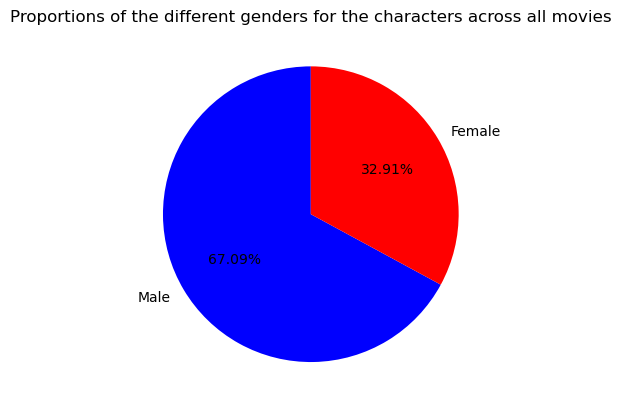

In [ ]:
#Assess women's presence accross all charaters from every movies
M_count = charadata_filtered[charadata_filtered.actor_gender == 'M'].shape[0]
F_count = charadata_filtered[charadata_filtered.actor_gender == 'F'].shape[0]

M_proportion = M_count / (M_count + F_count)
F_proportion = F_count / (M_count + F_count)

print("First we wish to have a look at the numbers and proportions of male and female characters across all movies :")
print("There are {} male characters, corresponding to {:.2f}% of all characters".format(M_count, M_proportion*100))
print("There are {} female characters, corresponding to {:.2f}% of all characters".format(F_count, F_proportion*100))

plt.pie([M_proportion, F_proportion], labels = ["Male", "Female"], startangle = 90, autopct = "%0.2f%%",colors=['blue','red'])
plt.title("Proportions of the different genders for the characters across all movies")
plt.show()

This result shows us that men seem to be heavily more represented, we will thus decompose these values in order to observe what underlies this trend. In consequence, we want to further assess the relative gender representation by looking at the relative proportions of male and female characters in each movie.

In [ ]:
#Assess average gender presence per movie 
gender_count_permovie = charadata_filtered.groupby('wiki_id').apply(lambda x : pd.Series({'nb_male' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'nb_female' : x[x.actor_gender == 'F'].shape[0]}))
                                                                                       
#Compute proportions of each gender per movie
gender_count_permovie['M_proportion'] = gender_count_permovie.nb_male / (gender_count_permovie.nb_male + gender_count_permovie.nb_female)
gender_count_permovie['F_proportion'] = gender_count_permovie.nb_female / (gender_count_permovie.nb_male + gender_count_permovie.nb_female)

gender_count_permovie.head()

,nb_male,nb_female,M_proportion,F_proportion
wiki_id,,,,
330,0,4,0.000000,1.000000
3217,9,3,0.750000,0.250000
3333,8,6,0.571429,0.428571
3746,10,3,0.769231,0.230769
3837,18,2,0.900000,0.100000


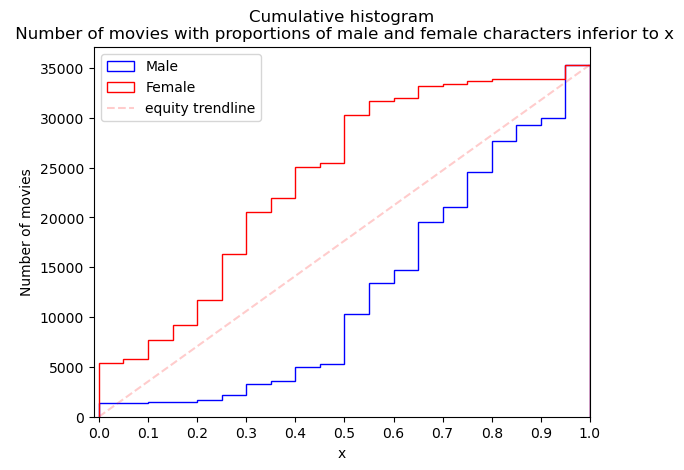

In [ ]:
plt.hist(gender_count_permovie.M_proportion, bins = 20, cumulative = True, histtype = 'step',label='Male',color='blue')
plt.hist(gender_count_permovie.F_proportion, bins = 20, cumulative = True, histtype = 'step',label='Female',color='red')
plt.plot([0,1], [0, gender_count_permovie.shape[0]], color = 'red', ls = '--', alpha = 0.2, label = 'equity trendline')
plt.xlim(-0.01,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.title("Cumulative histogram\n Number of movies with proportions of male and female characters inferior to x")
plt.xlabel('x')
plt.ylabel('Number of movies')
plt.legend(loc='upper left')
plt.show()

The graph above presents two cumulative histograms representing the number of movies in which the proportion of male or female characters is inferior to the corresponding proportion on the x-axis.

The dotted "equity trendline" represents the expected form of the cumulative histograms if the representations of each gender were equal, in the sens that the proportions of movies in which there is less than a certain proportion x of female (or male characters) should be equal to a proportion x of all movies. 

Therefore, any cumulative histogram under this trendline is biased towards the gender that it represents (i.e., this gender would be over-represented) and any cumulative histogram over the trendline represent a gender that would be under-represented. 

As one can see, male characters are significantly more represented than female characters as the numbers of movies in which they are show a certain proportion **x** of male characters which is always higher than this proportion **x** of the total numbers of movies. In the same way, female characters are significantly under-represented.

Below, we look at the proportion of movies starring different number of male and female actors. 

In [ ]:
max_M = 0
max_F = 0
equal_MF = 0
for i in range(gender_count_permovie.shape[0]) :
    if (gender_count_permovie.iloc[i]['nb_male'] > gender_count_permovie.iloc[i]['nb_female']) :
        max_M += 1
    elif (gender_count_permovie.iloc[i]['nb_male'] < gender_count_permovie.iloc[i]['nb_female']) : 
        max_F += 1
    elif (gender_count_permovie.iloc[i]['nb_male'] == gender_count_permovie.iloc[i]['nb_female']) :
        equal_MF += 1

print(f'The number of movies with more male actors than female actors is : {max_M}.')
print(f'The number of movies with more female actors than male actors is : {max_F}.')
print(f'The number of movies with equal number of male and female actors is : {equal_MF}.')

The number of movies with more male actors than female actors is : 25479.
The number of movies with more female actors than male actors is : 5248.
The number of movies with equal number of male and female actors is : 4598.


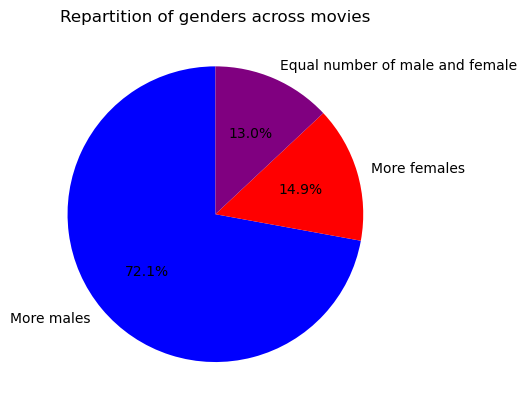

In [ ]:
plt.pie([max_M,max_F,equal_MF], labels = ["More males", "More females", "Equal number of male and female"], startangle = 90, autopct = "%0.1f%%",colors=['blue','red','purple'])
plt.title("Repartition of genders across movies")
plt.show()

To further analyze men and women representation in movies, we computed the mean, median and std of the number of movies each gender stars in. This helps to show further differences, as men tend to play in more movies than women.

In [ ]:
movies_count_peractor = charadata_filtered.groupby('actor_name').apply(lambda x : pd.Series({'actor_gender' : x['actor_gender'].unique()[0], 
                                                                                       'num_movies' : x.index.nunique()}))
movies_count_peractor.head()

,actor_gender,num_movies
actor_name,,
'King Kong' Kashey,M,1
2 Tuff Tony,M,1
40 Glocc,M,1
50 Cent,M,15
A Martinez,M,9


In [ ]:
mean_M = (movies_count_peractor[movies_count_peractor['actor_gender']=='M']['num_movies']).mean()
mean_F = (movies_count_peractor[movies_count_peractor['actor_gender']=='F']['num_movies']).mean()
median_M = (movies_count_peractor[movies_count_peractor['actor_gender']=='M']['num_movies']).median()
median_F = (movies_count_peractor[movies_count_peractor['actor_gender']=='F']['num_movies']).median()
std_M = (movies_count_peractor[movies_count_peractor['actor_gender']=='M']['num_movies']).std()
std_F = (movies_count_peractor[movies_count_peractor['actor_gender']=='F']['num_movies']).std()
print('Median number of movies per male actor =',median_M,'mean number of movies per male actor =',mean_M, 'std =',std_M)
print('Median number of movies per female actor =',median_F,'mean number of movies per female actor =',mean_F, 'std =',std_F)

Median number of movies per male actor = 2.0 mean number of movies per male actor = 5.392500257546101 std = 9.638695697080452
Median number of movies per female actor = 2.0 mean number of movies per female actor = 4.426107386396195 std = 6.494703442543116


Finally, another crucial aspect looking at women representation is the difference in age between men and women in movies. Indeed, women tend to be represented younger than men, and we wanted to assess this statement by looking at the distribution of ages of actors between genders.

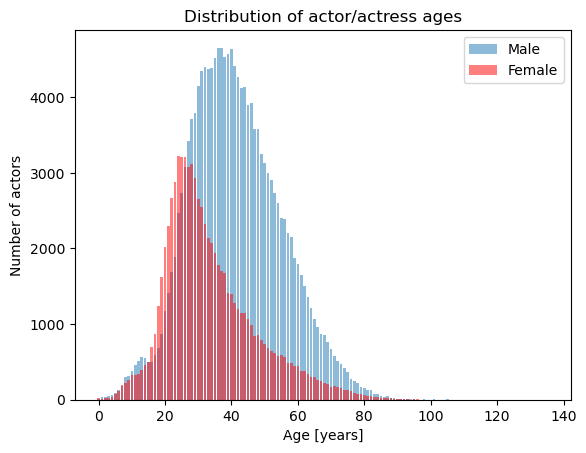

In [ ]:
#Plot age distribution across gender

df_wo_ol = charadata_filtered[charadata_filtered['actor_age']>=0]
M = df_wo_ol[df_wo_ol['actor_gender']=='M']
F = df_wo_ol[df_wo_ol['actor_gender']=='F']
Mc = M['actor_age'].value_counts()
Fc = F['actor_age'].value_counts()

plt.bar(np.sort(Mc.index),Mc[np.sort(Mc.index)],alpha=0.5,label='Male')
plt.bar(np.sort(Fc.index),Fc[np.sort(Fc.index)],alpha=0.5,label='Female', color = 'red')
plt.title("Distribution of actor/actress ages")
plt.xlabel('Age [years]')
plt.ylabel('Number of actors')
plt.legend(loc='upper right')
plt.show()

#### Analysis across time

As we want to analyse the `evolution` of some traits we need to focus on an analysis across time.

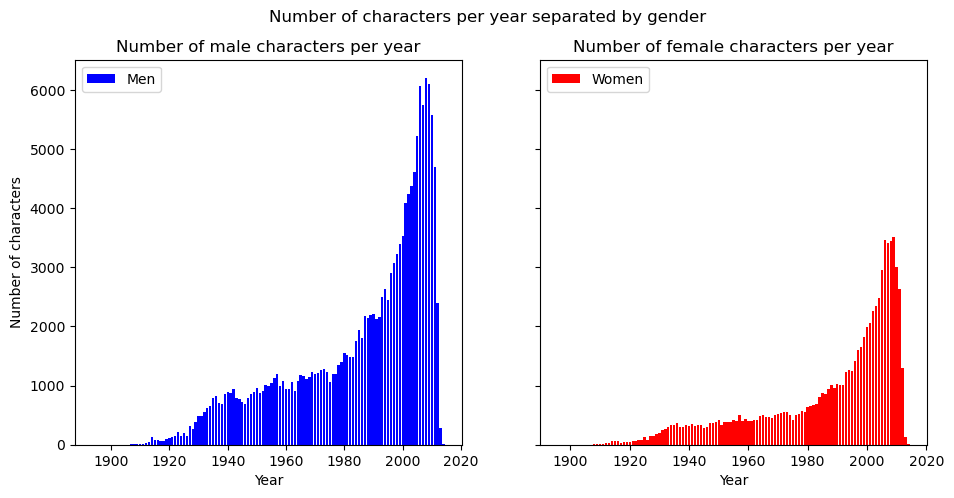

In [ ]:
#Look at gender distribution over time
labels_men, counts_men = (np.sort(charadata_filtered[charadata_filtered['actor_gender'] == 'M']['release'].unique())) , charadata_filtered[charadata_filtered['actor_gender'] == 'M'].groupby(['release', 'actor_gender'])['actor_gender'].count()
labels_women, counts_women = (np.sort(charadata_filtered[charadata_filtered['actor_gender'] == 'F']['release'].unique())) , charadata_filtered[charadata_filtered['actor_gender'] == 'F'].groupby(['release', 'actor_gender'])['actor_gender'].count()
fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(11, 5), sharey = True)

ax0.bar(labels_men, counts_men,label='Men', color = 'blue')
ax1.bar(labels_women, counts_women,label='Women', color = 'red')
ax0.legend(loc='upper left')
ax1.legend(loc='upper left')


ax0.set_title('Number of male characters per year')
ax1.set_title('Number of female characters per year')

ax0.set_ylabel('Number of characters')
ax0.set_xlabel('Year')
ax1.set_xlabel('Year')

fig.suptitle('Number of characters per year separated by gender')

plt.show()

Above, we can observe that there is a constant increase for each category across time from year to year there are no huge drop nor inrease of the number of characters. Thus, we decide to create a column which corresponds to the decade in which the movie was released. Grouping movies by decade still allows a fine temporal resolution with an increased amount of data to perform the analysis on temporal evolution. We devide the dataset by decade as it seems to us that in such a period, the lifestyle remains constant. Indeed, we can assume that the purchasing power, population, movie habits and genre popularity remained stable in each decade. 

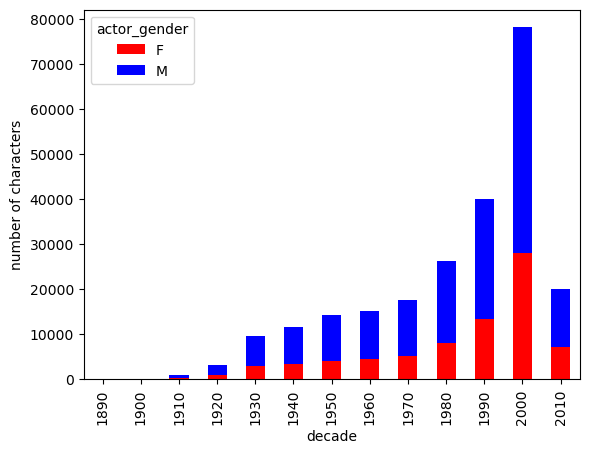

In [ ]:
# Add column for decade distinction
charadata_filtered['decade'] = (charadata_filtered['release']//10)*10

# Indicate its decade of release and the year in the decade (ie. 0,1,2,3,4,5,6,7,8,9)
moviedata_filtered['decade'] = (moviedata_filtered['release']//10)*10
moviedata_filtered['year'] = moviedata_filtered['release']%10

#Look at gender distribution along time
charadata_filtered.groupby(['decade', 'actor_gender'])['actor_gender'].count().unstack().plot.bar(stacked=True, color = ['red', 'blue'])
plt.ylabel('number of characters')
plt.show()

We can notice that 1910 and 1920 have only a few movies. We can visualize further how many there are per decade. Plus, we know that the data is driven from Wikipedia in 2012 so the 2010 decade is not complete, as we decide to focus on the evolution by decade we may need to remove the last incomplete decade.

In [ ]:
count_movies = charadata_filtered.groupby(['decade', 'actor_gender'])['actor_gender'].count()
count_movies

decade  actor_gender
1890    F                   2
        M                   3
1900    F                  16
        M                  35
1910    F                 379
        M                 637
1920    F                1024
        M                2068
1930    F                2979
        M                6642
1940    F                3367
        M                8210
1950    F                4069
        M               10150
1960    F                4501
        M               10746
1970    F                5216
        M               12390
1980    F                8083
        M               18044
1990    F               13263
        M               26684
2000    F               27930
        M               50182
2010    F                7057
        M               12977
Name: actor_gender, dtype: int64

We can see that the decade 1910 contains too few values for the gender analysis. We can remove it.

In [ ]:
moviedata_filtered = moviedata_filtered.loc[(moviedata_filtered['decade'] > 1910) & (moviedata_filtered['decade'] < 2010)]
charadata_filtered = charadata_filtered.loc[(charadata_filtered['decade'] > 1910) & (charadata_filtered['decade'] < 2010)]
print('We have now {} movies which contain all the necessary data for our analysis.'.format(len(moviedata_filtered)))
print('There are in average {:.2f} characters per movie.'.format(len(charadata_filtered)/len(moviedata_filtered)))

We have now 32249 movies which contain all the necessary data for our analysis.
There are in average 6.68 characters per movie.


After observing the number of men and women per decade to observe distribution, it makes sense to focus on relative distribution, as it is not easily readable in the above plots. Thus, we plotted both the proportion and ratio of men and women in the two visualizations below.

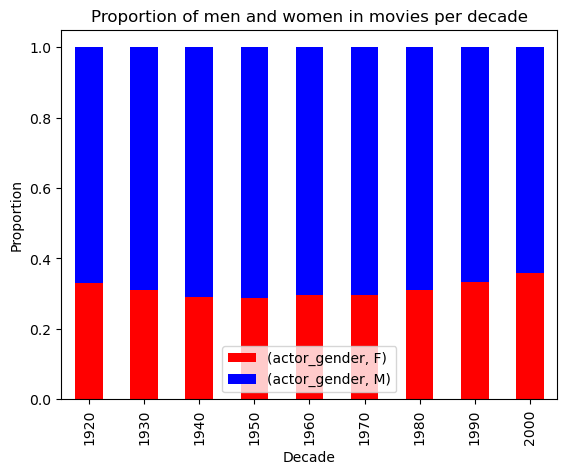

In [ ]:
#Plot proportion of genders across time
pd.DataFrame(
    charadata_filtered.groupby(
        ['decade', 'actor_gender'])['actor_gender'].count()/np.repeat(charadata_filtered.groupby(['decade']).size().values, 2)
        ).unstack().plot.bar(stacked=True,title='Proportion of men and women in movies per decade', xlabel='Decade',ylabel='Proportion',color=['red','blue'])
plt.legend()
plt.show()

In [ ]:
#Count male and female characters per decade across all movies
gender_count_perdecade = charadata_filtered.groupby('decade').apply(lambda x : pd.Series({'M' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'F' : x[x.actor_gender == 'F'].shape[0]}))
gender_count_perdecade['F_M_Ratio'] = gender_count_perdecade.F / (gender_count_perdecade.M + gender_count_perdecade.F)

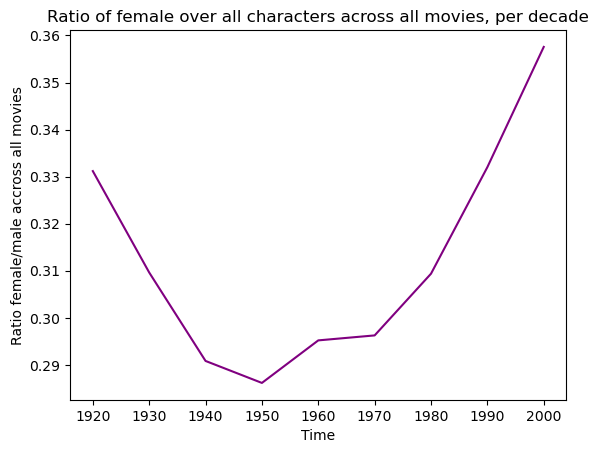

In [ ]:
plt.plot(gender_count_perdecade.index, gender_count_perdecade.F_M_Ratio, ls = '-',color='purple')
plt.title("Ratio of female over all characters across all movies, per decade")
plt.xlabel('Time')
plt.ylabel("Ratio female/male accross all movies")
plt.show()

Finally, as we observed the different ratios over time, it is interesting to also decompose the age distribution over decades, and try to see if we can observe an evolution within the general tendency. 

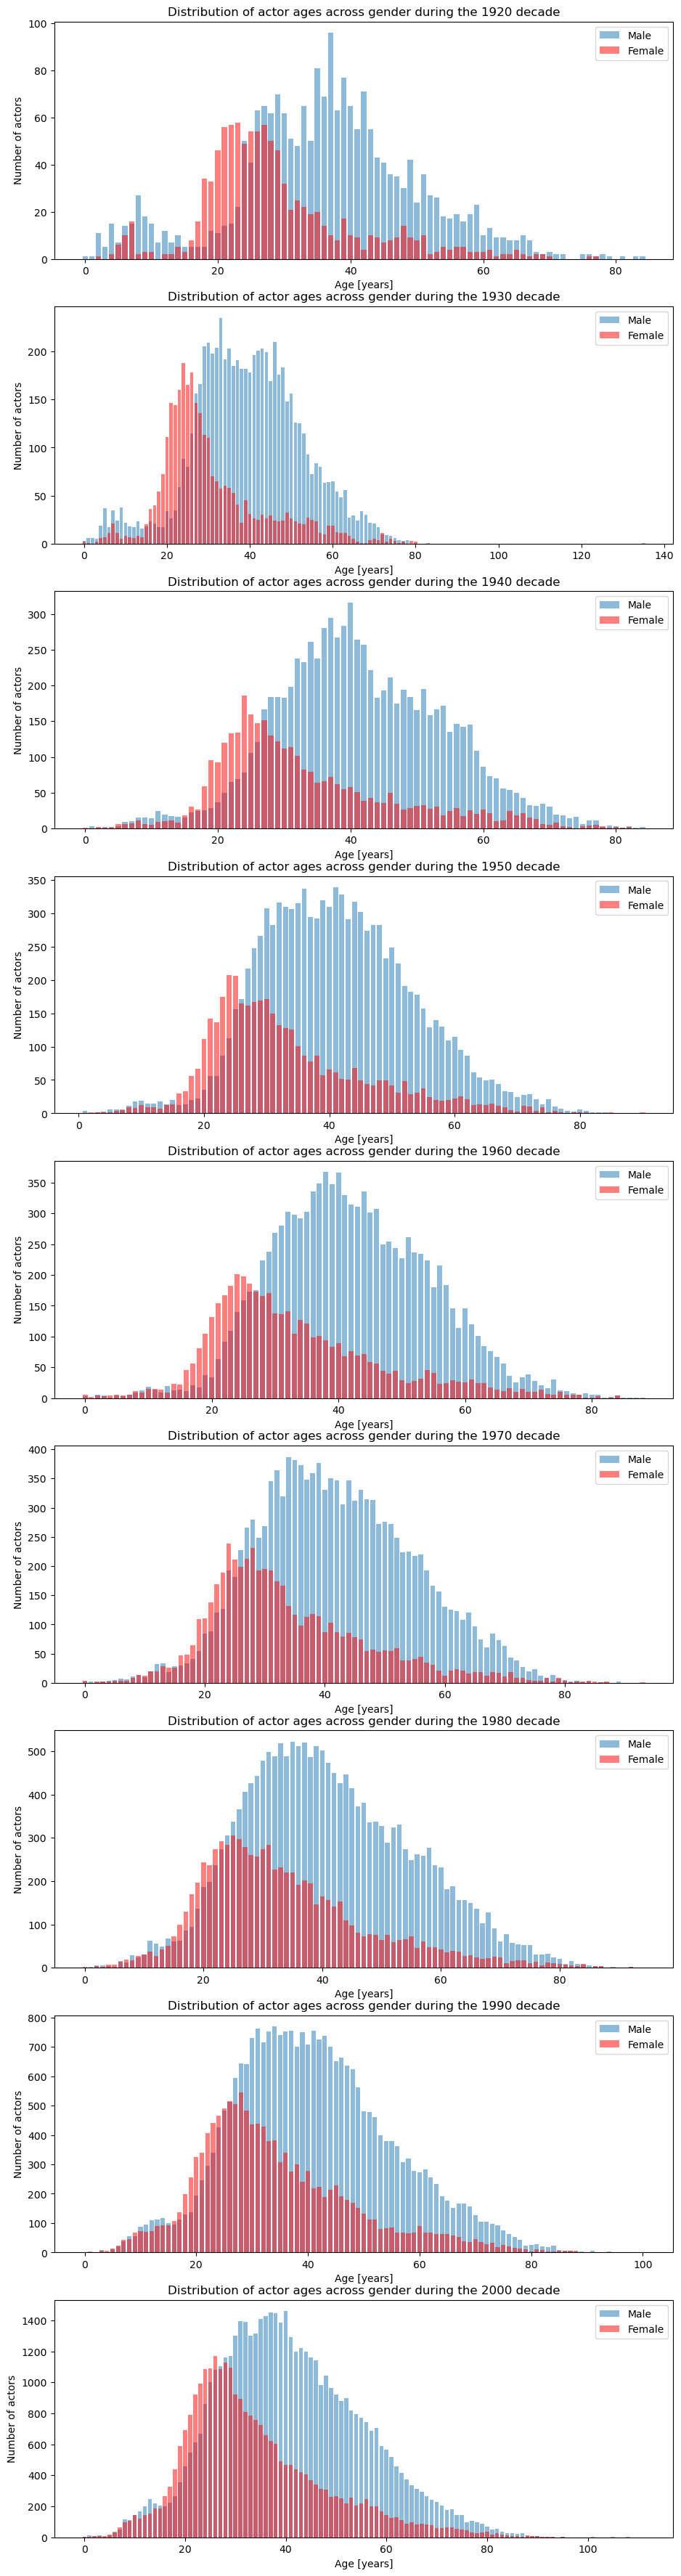

In [ ]:
fig,axs=plt.subplots(9,1,figsize=(11, 45))

decades=np.sort(charadata_filtered['decade'].unique())
for i, decade in enumerate(decades) : 
    M=charadata_filtered[(charadata_filtered['actor_gender']=='M') & (charadata_filtered['decade']==decade)]
    F=charadata_filtered[(charadata_filtered['actor_gender']=='F') & (charadata_filtered['decade']==decade)]
    Mc = M['actor_age'].value_counts()
    Fc = F['actor_age'].value_counts()
    
    axs[i].bar(np.sort(Mc.index),Mc[np.sort(Mc.index)],alpha=0.5,label='Male')
    axs[i].bar(np.sort(Fc.index),Fc[np.sort(Fc.index)],alpha=0.5,label='Female',color='red')
    axs[i].set_title(f"Distribution of actor ages across gender during the {decade} decade")
    axs[i].set_xlabel('Age [years]')
    axs[i].set_ylabel('Number of actors')
    axs[i].legend(loc='upper right')

The main observation regarding distributions' evolution is that women's age distribution seems to remain centered around 25 years old across time, while men's peak shifts from 30 to 40 years old.

One could think about looking at the women's representation in the film industry depending on geographical location.

In [ ]:
#input : takes a Series composed of lists of variavble sizes 
#output : a 1D Series with the lists placed end to end

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

Text(0, 0.5, 'Count')

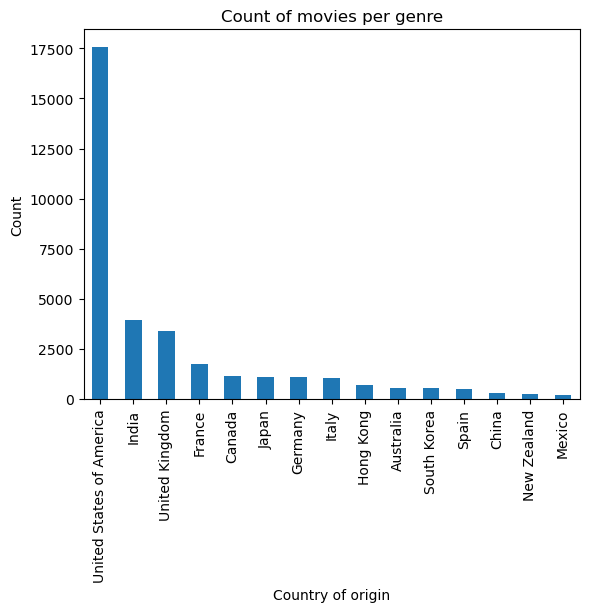

In [ ]:
#counts the number of movies sharing the same origin
#Plot the countries which have more than a thousand movies
count_origin = to_1D(moviedata_filtered['countries']).value_counts()
count_origin = count_origin[count_origin>200] 

count_origin.plot(kind='bar')
plt.title('Count of movies per genre')
plt.xlabel('Country of origin')
plt.ylabel('Count')

We can see that a great part of the dataset is composed of american movies, we do not have enough data to take into account the geographical parameter.

In [ ]:
DATA_FILTERED = "./Data_filtered/"
#import os
#os.mkdir(DATA_FILTERED)

moviedata_filtered.to_csv(DATA_FILTERED + "moviedata_filtered.csv")
charadata_filtered.to_csv(DATA_FILTERED + "charadata_filtered.csv")
plots_filtered.to_csv(DATA_FILTERED + "plots_filtered.csv")

# PEUT COMMENCER ICI 

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime #useful for date and time handling
import requests #used for getting data on the internet
from itertools import combinations  #used to create unique pairs from a list
import numpy as np
import plotly.express as px  #for plots with integrated cursor for better visualization
#from pandas_profiling import ProfileReport

DATA_FOLDER = "Data_filtered/"

#Create dataframes from the orignal dataset 
moviedata_filtered = pd.read_csv(DATA_FOLDER + 'moviedata_filtered.csv', index_col = 'wiki_id')
charadata_filtered = pd.read_csv(DATA_FOLDER + 'charadata_filtered.csv', index_col = 'wiki_id')
plots_filtered =  pd.read_csv(DATA_FOLDER + 'plots_filtered.csv', index_col = 'wiki_id')
plots = plots_filtered

#### ANALYSIS BY GENRE

Following the observed trends and results previously obtained, we would like to know wether these apply to distinct genres within the film industry. Analysis accross genres allows to determine the most popular ones which implies a superior impact on the society. Repeating steps previously done such as age and proportion of male vs female characters over time for distinct genres would allow to highligths effects common to the whole industry. Due to the variety of genres in the dataset, it would be better to focus on a lesser extent of genres with a sufficient count for relevance and that are as distinct as possible to study similarity.

In [236]:
#input : takes a Series composed of lists of variavble sizes 
#output : a 1D Series with the lists placed end to end

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [237]:
to_1D(moviedata_filtered['genres'].apply(eval).iloc[0])[0]

'D'

Text(0, 0.5, 'Count')

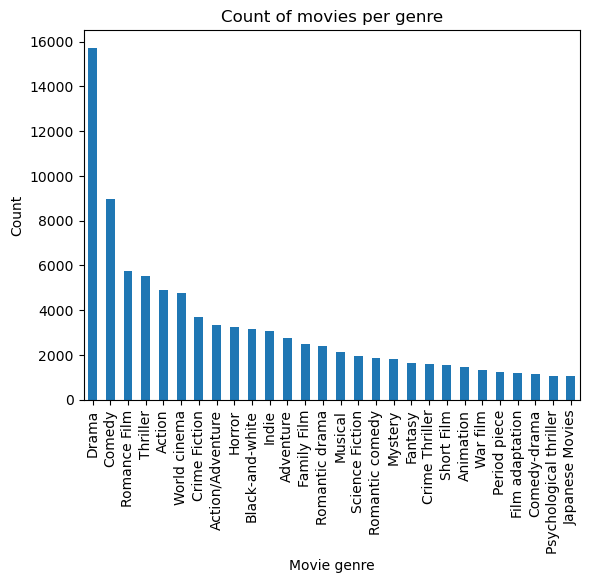

In [238]:
#counts the number of movies tagged with each genre 
#Plot the genres that contain more than a thousand movies
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(eval)
count_genres = to_1D(moviedata_filtered['genres']).value_counts()
count_genres = count_genres[count_genres>1000] 

count_genres.plot(kind='bar')
plt.title('Count of movies per genre')
plt.xlabel('Movie genre')
plt.ylabel('Count')

We decided to keep the top 10 genres with the highest movie counts to have a sufficient effect size for our following analysis. We notice that the genre World cinema is in the top 10. We decide to remove this genre as it represents all non-american movies while our dataset contains a great part of movies coming from the United States and that it is a movie genre per se.

In [239]:
selected = count_genres[:10].index #we take the 10 genres with the highest counts of movies
selected = selected.drop(['World cinema']) 
identification_genre = moviedata_filtered[['genres']].copy() #temporary dataframe for genre identification for each movie

In [240]:
#for each genre checks if the movie is part of a top 10 genre
for i in selected:
    identification_genre[str(i)] = identification_genre['genres'].apply(lambda x: 1 if i in x else 0) # for each genre chekcs if the movie is part of the genre

From these top 10 genres, we want to extract a combination of three genres that provides a sufficient count of movies that are listed in only one of the three genres, that have similar counts, and that have the lowest ratio of removed movies belonging to several genres of the three. This allows the extraction of a combination of three isolated genres. Indeed, this will result in three genres as independent as possible from each other with relative importance in the film industry due to a high movie count. It allows us to compare movies that belong to only one of the three different and independent genres to study if our following analysis shows the same results accross the film industry.

In [241]:
triplets = list((combinations(selected,3)))   # create all triplets possible for the selected genres
count_per_genre = np.zeros((len(triplets), 3))  # count number of movies for each genre for each triplet 
count_unique_per_genre = np.zeros((len(triplets), 3)) # count number of movies for each genre for each triplet which are not shared by the other genres of the triplet

for i, triplet in enumerate(triplets) :
    for j, genre in enumerate(triplet) :
        count_per_genre[i,j] = identification_genre.loc[:,genre].sum()  
        others = list(triplet)
        others.remove(genre)
        count_unique_per_genre[i,j] = len(identification_genre[(identification_genre[genre] == 1) \
            & (identification_genre[others[0]] != 1)\
            & (identification_genre[others[1]] != 1)])

In [242]:
#Criteria to select the genre triplet
loss_genres = (count_per_genre - count_unique_per_genre) / count_per_genre  
mean_loss = pd.Series(np.mean(loss_genres, axis=1), index = triplets) # mean per triplet of proportion of loss of number of shared movies    
genre_loss_std = pd.Series(np.std(loss_genres, axis=1), index = triplets) # std of loss of counts of movies in each triplet 
mean_count = pd.Series(np.mean(count_unique_per_genre, axis=1), index = triplets) # mean of counts of movies per triplet

In [243]:
evaluation_df = pd.concat([mean_loss,genre_loss_std,mean_count],axis=1)
evaluation_df.columns = ['mean count loss', 'std loss', 'mean counts']
fig = px.scatter(evaluation_df , x = 'mean count loss', y = 'std loss', color = 'mean counts', title="Scatter plot evaluating independence for genres in each triplet", width=716, height=750, hover_name = list(mean_count.index))
fig.show()

We can see that the triplet which looses few movie, in which the differences in count in the triplets is minimal and which has an overall higher mean of counts of movies than is neighbors in the triplet is Romance Film, Action and Horror. 

In [244]:
#Check that each movie belongs to only one of the genres present in the triplet
selected_genres = ['Romance Film', 'Action', 'Horror']

for genre in selected_genres:
    moviedata_filtered[genre] = moviedata_filtered['genres'].apply(lambda x: 1 if genre in x else 0)

moviedata_filtered['unique_genre'] = moviedata_filtered.loc[:,selected_genres].sum(axis = 1)

In [245]:
#Drop movies that belong to more than one genre in the triplet or none of them
unique_genre = moviedata_filtered.drop(moviedata_filtered[moviedata_filtered['unique_genre'] != 1].index)

<AxesSubplot:>

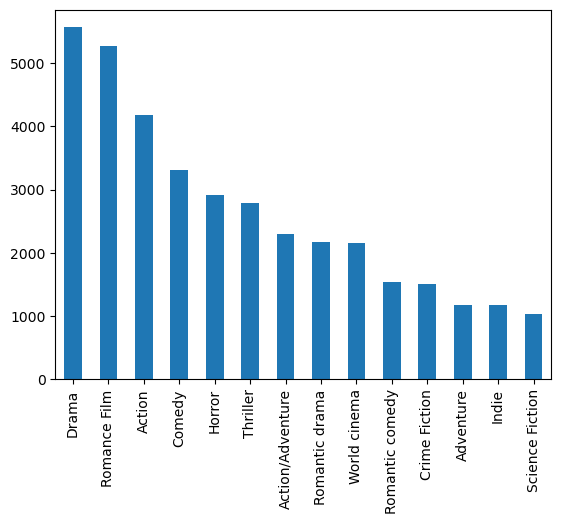

In [246]:
#Plot the distribution of count of movies that belong to one genre in the triplets
count_selected = to_1D(unique_genre['genres']).value_counts()

count_selected = count_selected[count_selected>1000]

count_selected.plot(kind='bar')

We notice that comedy and Drama have a high count of movies. This means that the movies filtered at this point from the dataset belong in addition to one of the triplet genre to Drama or Comedy. This higlights the fact that these genre are more general than others.

In [247]:
unique_genre.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
20663735,Narasimham,2000,['India'],"[Action, Musical, Drama, Bollywood]",2000,0,0,1,0,1
5272176,End Game,2006,"['Germany', 'United States of America', 'Canada']","[Action, Drama, Action/Adventure, Thriller]",2000,6,0,1,0,1
1952976,Dark Water,2005,['United States of America'],"[Drama, Thriller, Horror]",2000,5,0,0,1,1
2462689,Meet John Doe,1941,['United States of America'],"[Black-and-white, Comedy, Media Satire, Romanc...",1940,1,1,0,0,1
1335380,Exodus,1960,['United States of America'],"[Action, Film adaptation, Action/Adventure, Wa...",1960,0,0,1,0,1


In [248]:
#Select the genre of the triplet to which the movie belongs
for genre in selected_genres:
    unique_genre['genres'] = unique_genre['genres'].apply(lambda x: genre if genre in x else x)

In [249]:
unique_genre.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
20663735,Narasimham,2000,['India'],Action,2000,0,0,1,0,1
5272176,End Game,2006,"['Germany', 'United States of America', 'Canada']",Action,2000,6,0,1,0,1
1952976,Dark Water,2005,['United States of America'],Horror,2000,5,0,0,1,1
2462689,Meet John Doe,1941,['United States of America'],Romance Film,1940,1,1,0,0,1
1335380,Exodus,1960,['United States of America'],Action,1960,0,0,1,0,1


In [250]:
print('Looking at these three specific genres we can study the evolution of women represention in {} movies'.format(len(unique_genre)))

Looking at these three specific genres we can study the evolution of women represention in 12362 movies


In [251]:
#Split the previous dataframe in three distinct ones for each genre to allow parallel analysis
horror = unique_genre.loc[unique_genre['genres'] == 'Horror'].copy()
action = unique_genre.loc[unique_genre['genres'] == 'Action'].copy()
romance = unique_genre.loc[unique_genre['genres'] == 'Romance Film'].copy()

In [252]:
#counts the amount of revenues provided in each genre
horror_count = len(horror.index)
action_count = len(action.index)
romance_count = len(romance.index)
print('We have now {} horror movies extracted.'.format(horror_count))
print('We have now {} horror movies extracted.'.format(action_count))
print('We have now {} horror movies extracted.'.format(romance_count))

We have now 2906 horror movies extracted.
We have now 4179 horror movies extracted.
We have now 5277 horror movies extracted.


Now we will look at the evolution of the number of movies per decade for each of the three genres selected.

Text(0, 0.5, 'Number of movies')

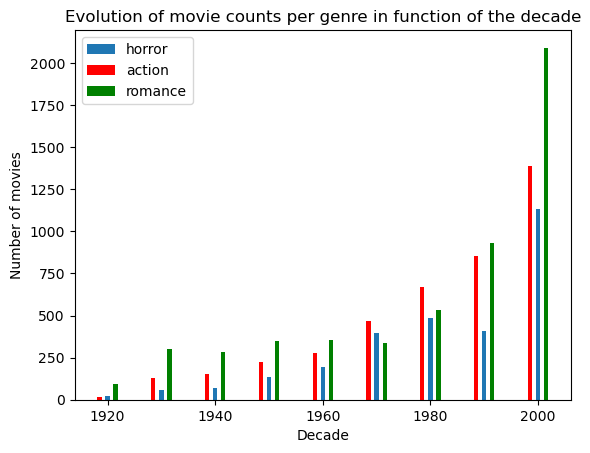

In [253]:
#Plot the evolution of the movie count per genre and per decade 
plt.bar(horror['decade'].sort_values().unique(), horror.groupby(['decade'])['release'].count(), label = 'horror')
plt.bar(action['decade'].sort_values().unique() - 1.5, action.groupby(['decade'])['release'].count(), color='red', label = 'action')
plt.bar(romance['decade'].sort_values().unique() + 1.5, romance.groupby(['decade'])['release'].count(), color= 'green', label = 'romance')

plt.legend(loc = 'upper left')
plt.title('Evolution of movie counts per genre in function of the decade')
plt.xlabel('Decade')
plt.ylabel('Number of movies')

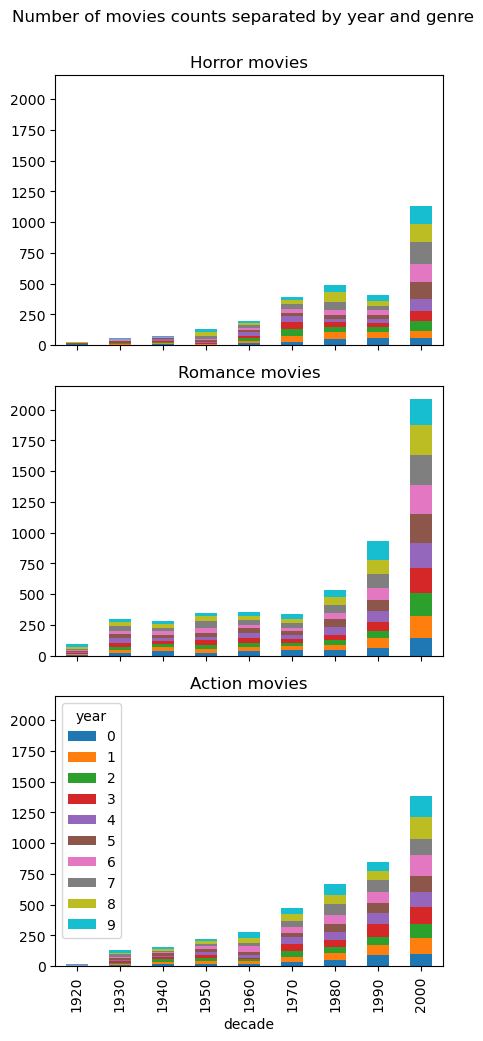

In [254]:
#Subplot the evolution of the movie per decade for each genre with the detailed count per year
fig = plt.figure(figsize=(5, 11))
gs = fig.add_gridspec(3, hspace=0.15)
axs = gs.subplots(sharex=True, sharey=True)

horror.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(ax = axs[0], stacked=True)
romance.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(ax = axs[1], stacked=True)
action.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(ax = axs[2], stacked=True)

axs[0].get_legend().remove()
axs[1].get_legend().remove()

axs[0].title.set_text('Horror movies')
axs[1].title.set_text('Romance movies')
axs[2].title.set_text('Action movies')

fig.suptitle('Number of movies counts separated by year and genre')
fig.subplots_adjust(top=0.92)

##### Analysis on character's list

In [255]:
#Select characters according to movies belonging to one of the three genres
horror_charadata = charadata_filtered.loc[horror.index.intersection(charadata_filtered.index)]
action_charadata = charadata_filtered.loc[action.index.intersection(charadata_filtered.index)]
romance_charadata = charadata_filtered.loc[romance.index.intersection(charadata_filtered.index)]
horror_charadata.head()

,release,character_name,actor_gender,actor_name,actor_age,decade
wiki_id,,,,,,
1952976,2005,Mediator,F,Linda Emond,46.0,2000
1952976,2005,Dahlia,F,Jennifer Connelly,34.0,2000
1952976,2005,Mr. Murray,M,John C. Reilly,40.0,2000
1952976,2005,Jeff Platzer,M,Tim Roth,44.0,2000
1952976,2005,Kyle Williams,M,Dougray Scott,39.0,2000


In [256]:
#Function which analyses character information such as age and gender and compare men and women characteristics
def count_chara(genre_data,character_genre):
    character_genre = character_genre.groupby('wiki_id')
    nb_characters = character_genre['actor_gender'].count()
    genre_data['nb_characters'] = nb_characters
    genre_data['nb_women'] = character_genre['actor_gender'].apply(lambda x: x[x == 'F'].count())
    genre_data['nb_men'] = character_genre['actor_gender'].apply(lambda x: x[x == 'M'].count())
    genre_data['ratio_gender'] = genre_data['nb_women'] / genre_data['nb_men']
    genre_data['average_age_men'] = character_genre.apply(lambda x: x['actor_age'].loc[x['actor_gender'] == 'M'].mean())
    genre_data['average_age_women'] = character_genre.apply(lambda x: x['actor_age'].loc[x['actor_gender'] == 'F'].mean())

In [257]:
count_chara(horror, horror_charadata)
count_chara(action, action_charadata)
count_chara(romance, romance_charadata)

In [258]:
# The function computes the means of the age of men and women actors as well as the standard deviations for each decade 

def stats_age_decade(genre_charadata):

    genre_age = genre_charadata.groupby(['decade'])
    mean_age_men = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'M']['actor_age'].mean())
    std_age_men = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'M']['actor_age'].std())
    mean_age_women = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'F']['actor_age'].mean())
    std_age_women = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'F']['actor_age'].std())

    return mean_age_men, std_age_men, mean_age_women, std_age_women

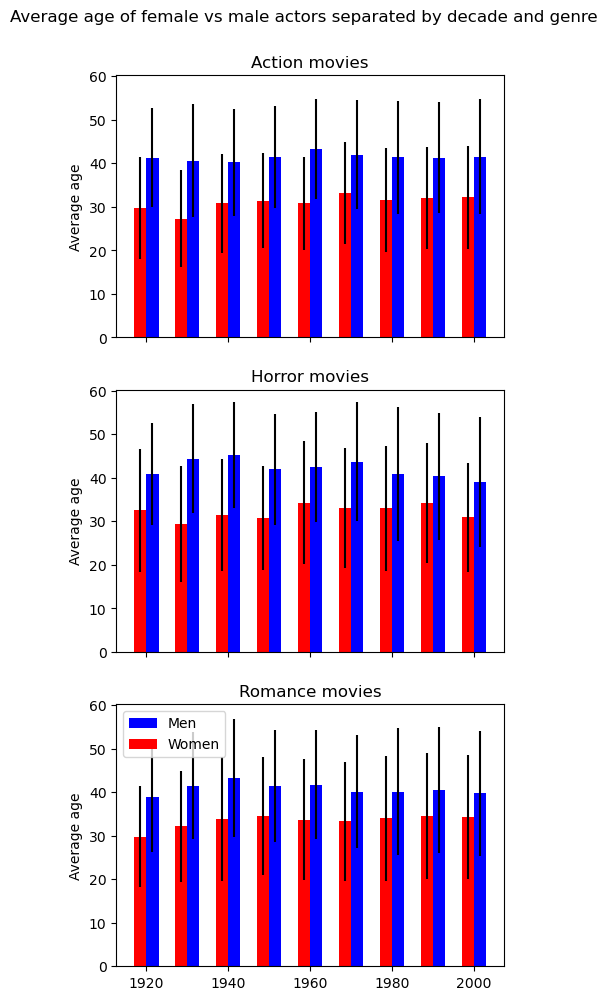

In [259]:
# Compute some stats for the three selected genres and plot them by decade for each genre
action_age = stats_age_decade(action_charadata)
horror_age = stats_age_decade(horror_charadata)
romance_age = stats_age_decade(romance_charadata)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(5, 11), sharex = True, sharey = True)
width = 3

ax0.bar(action_age[0].index + width/2, action_age[0],width, yerr = action_age[1],label='Men', color = 'blue')
ax0.bar(action_age[2].index - width/2, action_age[2],width, yerr = action_age[3],  label='Women', color = 'red')
ax1.bar(horror_age[0].index + width/2, horror_age[0],width, yerr = horror_age[1],label='Men', color = 'blue')
ax1.bar(horror_age[2].index - width/2, horror_age[2],width, yerr = horror_age[3],  label='Women', color = 'red')
ax2.bar(romance_age[0].index + width/2, romance_age[0],width, yerr = romance_age[1],label='Men', color = 'blue')
ax2.bar(romance_age[2].index - width/2, romance_age[2],width, yerr = romance_age[3],  label='Women', color = 'red')


ax0.set_title('Action movies')
ax1.set_title('Horror movies')
ax2.set_title('Romance movies')

ax0.set_ylabel('Average age')
ax1.set_ylabel('Average age')
ax2.set_ylabel('Average age')

ax2.legend(loc='upper left')

fig.suptitle('Average age of female vs male actors separated by decade and genre')
fig.subplots_adjust(top=0.92)

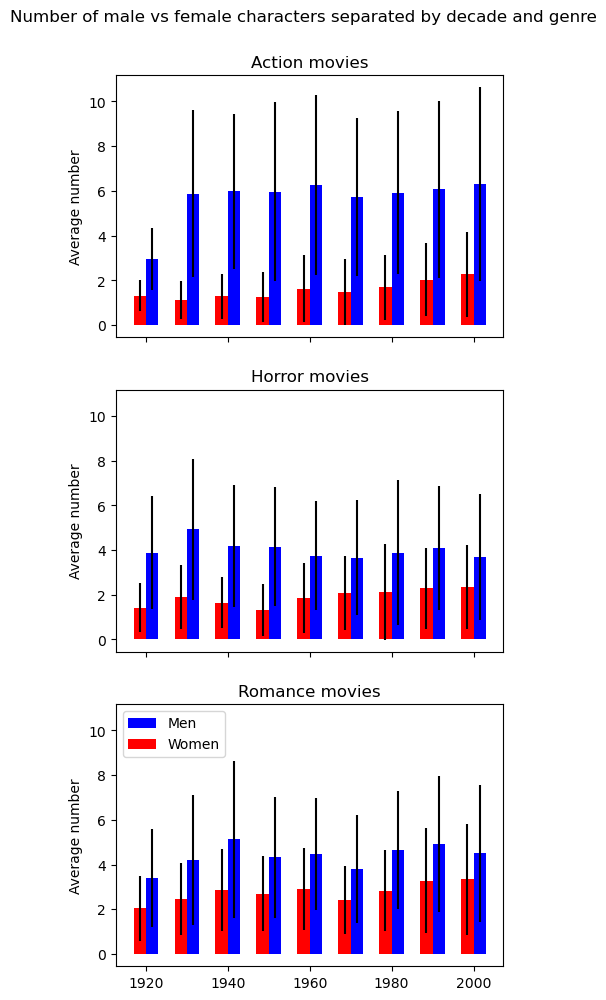

In [260]:
#Plot the average number of men vs women for each genre over time

width = 3
action_nb_men = action.groupby(['decade'])['nb_men']
action_nb_women = action.groupby(['decade'])['nb_women']
horror_nb_men = horror.groupby(['decade'])['nb_men']
horror_nb_women = horror.groupby(['decade'])['nb_women']
romance_nb_men = romance.groupby(['decade'])['nb_men']
romance_nb_women = romance.groupby(['decade'])['nb_women']

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(5, 11), sharex = True, sharey = True)

ax0.bar(action['decade'].sort_values().unique() + width/2, action_nb_men.mean(),width, yerr = action_nb_men.std(),label='Men', color = 'blue')
ax0.bar(action['decade'].sort_values().unique() - width/2, action_nb_women.mean(),width, yerr = action_nb_women.std(),  label='Women', color = 'red')
ax1.bar(action['decade'].sort_values().unique() + width/2, horror_nb_men.mean(),width, yerr = horror_nb_men.std(),label='Men', color = 'blue')
ax1.bar(action['decade'].sort_values().unique() - width/2, horror_nb_women.mean(),width, yerr = horror_nb_women.std(),  label='Women', color = 'red')
ax2.bar(action['decade'].sort_values().unique() + width/2, romance_nb_men.mean(),width, yerr = romance_nb_men.std(),label='Men', color = 'blue')
ax2.bar(action['decade'].sort_values().unique() - width/2, romance_nb_women.mean(),width, yerr = romance_nb_women.std(),  label='Women', color = 'red')

ax0.set_title('Action movies')
ax1.set_title('Horror movies')
ax2.set_title('Romance movies')

ax0.set_ylabel('Average number')
ax1.set_ylabel('Average number')
ax2.set_ylabel('Average number')

ax2.legend(loc='upper left')

fig.suptitle('Number of male vs female characters separated by decade and genre')
fig.subplots_adjust(top=0.92)

### Language Analysis

In this section, we perform a language extraction using the Supplement: Stanford CoreNLP-processed summaries folder. This contains a series of xml files for each plot summary from the movies above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Following the article `Learning Latent Personas of Film Characters David Bamman, Brendan O'Connor, and Noah A. Smith ACL 2013, Sofia, Bulgaria, August 2013`,
we will work on the extraction following cc-processed dependencies from the typed dependency tuples produced by the parser which is collapsed dependencies with propagation of conjunct dependencies. We extract linguistic features such as agent verbs, patient verbs and attributes for each character to evaluate its importance and level of description in the movie. We can therefore evaluate the relevance of female vs male characters for each movie and its evolution accross decades. 

We extract the headwords which are in tuples with the name of each the character and devide them as follows:

• Agent verbs: Verbs for which the entity is an agent argument (nsubj or agent).

• Patient verbs: Verbs for which the entity is the patient, theme or other argument (dobj, nsubjpass, iobj, or any prepositional argument starting with prep_).

• Attributes: Adjectives and common noun words that relate to the mention as adjectival modifiers, noun-noun compounds, appositives, or copulas (nsubj or appos governors, or nsubj, appos, amod, nn dependents of an entity mention).

In [261]:
from bs4 import BeautifulSoup #used to parse the xml files 
from bs4 import SoupStrainer #used to get only the a subset of data in the xml file 
import gzip #used to unzip and open the xml files 
import re #used to remove all strange characters in string such as ?! which impair comparinson between string and xml values

NLP_FOLDER = 'CoreNLP/corenlp_plot_summaries/'

First, to extract male and female characteritics we need the character names to identify the relevant words in the xml files. Therefore we remove all characters without name from our filtered character dataset used in the previous analysis.

In [262]:
#select only caharacters for which we have both the gender and the charcter name to allow langage analysis
charadata_2 = charadata_filtered[charadata_filtered["character_name"].notna()]
intersection = moviedata_filtered.index.intersection(charadata_2.index)
intersection = plots.index.intersection(intersection)

charadata_2 = charadata_2.reset_index()
movie_2 = moviedata_filtered.loc[intersection, :'year']
movie_2 = movie_2.reset_index()

In order to get representative results in the film industry while reducing time consumption we decided to perform the language analysis on the same amount of movies per decade for consistency. We thus randomly select 500 movies for each decade in the previous dataset.

In [263]:
# select 1000 random movies per decade from 1940 to process a langage analysis on the plots
rng = np.random.default_rng(7)

decades = np.arange(1940,2001,10)
sample = []
for decade in decades:
    char_movie = charadata_2[charadata_2['decade'] == decade]
    sample = np.append(sample, rng.choice(char_movie.wiki_id.unique(), size=500, replace = False))


movie_2 = movie_2[movie_2["wiki_id"].isin(sample)]
charadata_2 = charadata_2[charadata_2["wiki_id"].isin(sample)]

charadata_2 = charadata_2.set_index('wiki_id')
movie_2 = movie_2.set_index('wiki_id')

In [264]:
# The function counts the number of time a male or female character has been mentioned in the plot 
# Input: takes list to find character's name occurences from tuple produced by CoreNLP parser, the wiki_id of the movie,
#        dataframes of the movies' data and the characters' data,and string for the role type (i.e. agent, patient, attributes)

def count_chara_NLP(list_name_parser, movie_id, movie_data, movie_chara, character_data, type_):

    list_valid_type = ("patient", "agent", "attributes")
    if type_ not in list_valid_type:
        raise ValueError("Wrong role type, either: patient, agent, attributes")
        
    # For every element extracted from the tuples of the CoreNLP pipeline, add count in the data of the corresponding movie
    for elem in enumerate(list_name_parser):
        for i, chara in enumerate(movie_chara['character_name']):
            name_split = chara.split()
            for name_sep in name_split:
                if elem[1][0] == name_sep: # if name_sep.casefold() in map(str.casefold, list_name_parser):
                    # Count number of words associated to women or men depending of the role type_ analyzed
                    index = character_data[(character_data.wiki_id == movie_id) & (character_data['character_name'] == chara)].index[0]
                    col = character_data.columns.get_loc(type_)
                    character_data.iat[index, col] = character_data.iat[index, col] + [elem[1][1]]

                    # gender = ''.join(character_data.iloc[index]['actor_gender'].split())
                    if ('M' in movie_chara.iloc[i]['actor_gender']):
                        movie_data.loc[movie_id, str(type_ + '_man')] += 1
                    elif ('F' in movie_chara.iloc[i]['actor_gender']):
                        movie_data.loc[movie_id, str(type_ + '_woman')] += 1

# It opens the xml file for each movie in our sample dataset
# Fill the lists of all agent verbs, patient verbs and attributes pressent in the collapsed-ccprocessed-dependencies subpart of the xml file 
# Fill the characteritics columns of all characters for each movie

def extract_xml (movie_data, character_data):

    for movie_id in movie_data.index :
        with gzip.open(NLP_FOLDER + str(movie_id) +'.xml.gz', 'r') as f:
            data = f.read()
        cc_processed = SoupStrainer("collapsed-ccprocessed-dependencies")
        soup = BeautifulSoup(data, "xml", parse_only=cc_processed)
    
        # get the text for one element of the tuples extracted by the parser depending of the list of elements extract
        agent = [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'nsubj'})]
        agent += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'agent'})]
        agent = [[re.sub(r"[^a-zA-Z0-9]","",i[0]),re.sub(r"[^a-zA-Z0-9]","",i[1])] for i in agent] # filter out non alphabetical or numerical characters found

        patient = [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'dobj'})]
        patient += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'nsubjpass'})]
        patient += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'iobj'})]
        patient += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep', type = lambda value: value and value.startswith('prep_'))]
        patient = [[re.sub(r"[^a-zA-Z0-9]","",i[0]),re.sub(r"[^a-zA-Z0-9]","",i[1])] for i in patient]

        attributes = [[a.find('governor').get_text(), a.find('dependent').get_text()] for a in soup.find_all('dep',{'type':'nsubj'})]
        attributes += [[a.find('governor').get_text(), a.find('dependent').get_text()] for a in soup.find_all('dep',{'type':'appos'})]
        attributes += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'nsubj'})]
        attributes += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'appos'})]
        attributes += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'amod'})]
        attributes += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'nn'})]
        attributes = [[re.sub(r"[^a-zA-Z0-9]","",i[0]),re.sub(r"[^a-zA-Z0-9]","",i[1])] for i in attributes]
        

        movie_chara = character_data[character_data.wiki_id == movie_id][['character_name','actor_gender']].reset_index().copy()
        movie_chara = movie_chara[~movie_chara.isnull().any(axis=1)]
        
        count_chara_NLP(agent, movie_id, movie_data, movie_chara, character_data, "agent")
        count_chara_NLP(patient, movie_id, movie_data, movie_chara, character_data, "patient")
        count_chara_NLP(attributes, movie_id, movie_data, movie_chara, character_data, "attributes")

In [265]:
#Create and initialise colums of the dataframe to count agent verbs, patient verbs and attributes for each character and each movie

charadata_2['agent'] = [[]]*len(charadata_2)
charadata_2['patient'] = [[]]*len(charadata_2)
charadata_2['attributes'] = [[]]*len(charadata_2)


movie_2 = movie_2.assign(agent_woman = lambda x : 0)
movie_2 = movie_2.assign(patient_woman = lambda x : 0)
movie_2 = movie_2.assign(attributes_woman = lambda x : 0)
movie_2 = movie_2.assign(agent_man = lambda x : 0)
movie_2 = movie_2.assign(patient_man = lambda x : 0)
movie_2 = movie_2.assign(attributes_man = lambda x : 0)

charadata_2.reset_index(inplace = True)
charadata_2.head()

,wiki_id,release,character_name,actor_gender,actor_name,actor_age,decade,agent,patient,attributes
0,2940516,1973,Ras Mohammed,M,Peter Boyle,37.0,1970,[],[],[]
1,1335380,1960,Ari Ben Canaan,M,Paul Newman,35.0,1960,[],[],[]
2,1335380,1960,Dov Landau,M,Sal Mineo,21.0,1960,[],[],[]
3,1480747,1991,Sheila Landreaux,F,Iman Abdulmajid,36.0,1990,[],[],[]
4,1480747,1991,Bilal,M,Martin Lawrence,26.0,1990,[],[],[]


In [266]:
extract_xml(movie_2,charadata_2)

In [267]:
movie_2.head()

,movie_name,release,countries,genres,decade,year,agent_woman,patient_woman,attributes_woman,agent_man,patient_man,attributes_man
wiki_id,,,,,,,,,,,,
2940516,Ghost In The Noonday Sun,1973,['United Kingdom'],"[Parody, Comedy]",1970,3,0,0,0,0,0,0
1335380,Exodus,1960,['United States of America'],"[Action, Film adaptation, Action/Adventure, Wa...",1960,0,0,0,0,13,4,21
1480747,House Party 2,1991,['United States of America'],"[Coming of age, Comedy, Teen, Cult]",1990,1,8,9,9,9,3,9
33269085,Kehtaa Hai Dil Baar Baar,2002,"['India', 'United States of America']","[Romance Film, Comedy film]",2000,2,0,0,0,0,1,1
447194,Samson and Delilah,1949,['United States of America'],"[Action, Drama, History, Romance Film, Adventure]",1940,9,4,5,5,6,16,10


In [268]:
charadata_2.head()

,wiki_id,release,character_name,actor_gender,actor_name,actor_age,decade,agent,patient,attributes
0,2940516,1973,Ras Mohammed,M,Peter Boyle,37.0,1970,[],[],[]
1,1335380,1960,Ari Ben Canaan,M,Paul Newman,35.0,1960,"[obtains, smuggles, threatens, fallen, devise,...","[raised, wounded]","[rebel, obtains, smuggles, threatens, fallen, ..."
2,1335380,1960,Dov Landau,M,Sal Mineo,21.0,1960,"[proclaims, goes, successfully, turns, assures...","[finds, forces]","[proclaims, goes, successfully, turns, assures..."
3,1480747,1991,Sheila Landreaux,F,Iman Abdulmajid,36.0,1990,[approaches],"[attention, heard, name]",[approaches]
4,1480747,1991,Bilal,M,Martin Lawrence,26.0,1990,"[arrives, causes, arrive, convinces, reminds, ...","[approached, faces, campus]","[arrives, causes, arrive, convinces, reminds, ..."


In [269]:
#convert to csv
movie_2.to_csv('movie_langage_data.csv')

Now, we can visualize the repartition and evolution of the proportion of word used to described female characters compared to male over time.

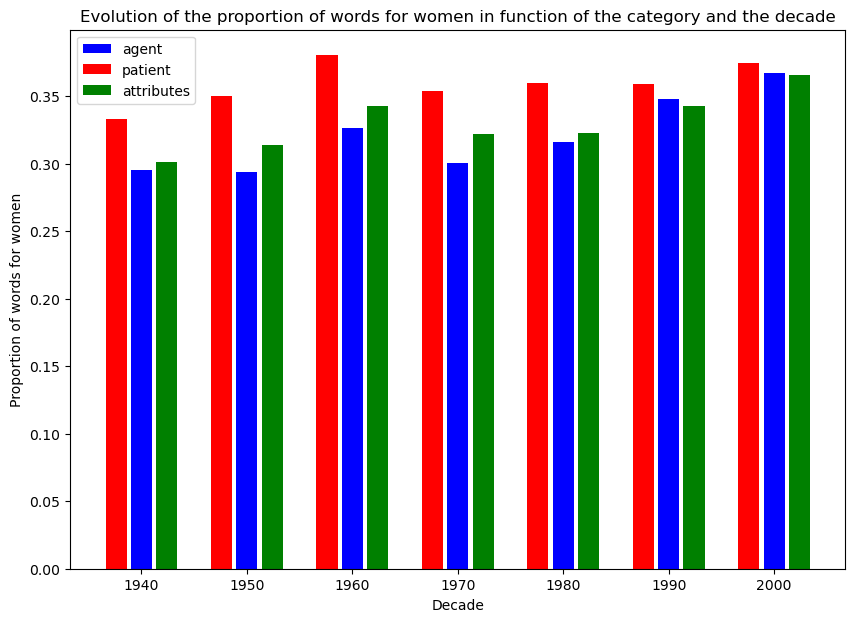

In [270]:
width = 3

movie_2_grp = movie_2.groupby(['decade'])
agent_mean = movie_2_grp.apply(lambda x : (x['agent_woman']/(x['agent_man'] + x['agent_woman'])).mean())
agent_std = movie_2_grp.apply(lambda x : (x['agent_woman']/(x['agent_man'] + x['agent_woman'])).std())
patient_mean = movie_2_grp.apply(lambda x : (x['patient_woman']/(x['patient_man'] + x['patient_woman'])).mean())
patient_std = movie_2_grp.apply(lambda x : (x['patient_woman']/(x['patient_man'] + x['patient_woman'])).std())
attributes_mean = movie_2_grp.apply(lambda x : (x['attributes_woman']/(x['attributes_man'] + x['attributes_woman'])).mean())
attributes_std = movie_2_grp.apply(lambda x : (x['attributes_woman']/(x['attributes_man'] + x['attributes_woman'])).std())

plt.figure(figsize=(10, 7))

plt.bar(agent_mean.index, agent_mean,width/1.5,label='agent', color = 'blue')
plt.bar(patient_mean.index - width/1.25, patient_mean,width/1.5,  label='patient', color = 'red')
plt.bar(attributes_mean.index + width/1.25, attributes_mean,width/1.5,  label='attributes', color = 'green')


plt.legend(loc = 'upper left')
plt.title('Evolution of the proportion of words for women in function of the category and the decade')
plt.xlabel('Decade')
plt.ylabel('Proportion of words for women')
plt.show()

We can notice a very small increase of the proportion of words for women overtime between 1970s and 2000s. This can result from a higher amount of descriptive words for woman or an higher amount of woman playing in the movies. Another possibility is that the amount of words for male character decreased.

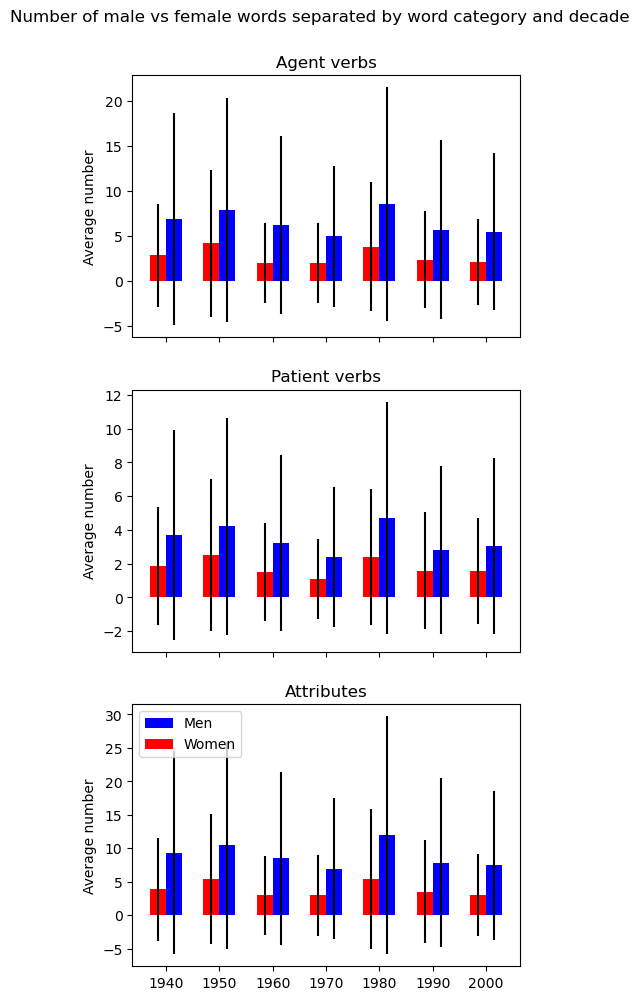

In [271]:
#Plot the average number of men vs women words for each word category separated by decade
width = 3
movie_2_grp = movie_2.groupby(['decade'])
agent_nb_men = movie_2_grp['agent_man']
agent_nb_women = movie_2_grp['agent_woman']
patient_nb_men = movie_2_grp['patient_man']
patient_nb_women = movie_2_grp['patient_woman']
attributes_nb_men = movie_2_grp['attributes_man']
attributes_nb_women = movie_2_grp['attributes_woman']

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(5, 11), sharex = True, sharey = False)

ax0.bar(movie_2['decade'].unique() + width/2, agent_nb_men.mean(),width, yerr = agent_nb_men.std(),label='Men', color = 'blue')
ax0.bar(movie_2['decade'].unique() - width/2, agent_nb_women.mean(),width, yerr = agent_nb_women.std(),  label='Women', color = 'red')
ax1.bar(movie_2['decade'].unique() + width/2, patient_nb_men.mean(),width, yerr = patient_nb_men.std(),label='Men', color = 'blue')
ax1.bar(movie_2['decade'].unique() - width/2, patient_nb_women.mean(),width, yerr = patient_nb_women.std(),  label='Women', color = 'red')
ax2.bar(movie_2['decade'].unique() + width/2, attributes_nb_men.mean(),width, yerr = attributes_nb_men.std(),label='Men', color = 'blue')
ax2.bar(movie_2['decade'].unique() - width/2, attributes_nb_women.mean(),width, yerr = attributes_nb_women.std(),  label='Women', color = 'red')

ax0.set_title('Agent verbs')
ax1.set_title('Patient verbs')
ax2.set_title('Attributes')

ax0.set_ylabel('Average number')
ax1.set_ylabel('Average number')
ax2.set_ylabel('Average number')

ax2.legend(loc='upper left')

fig.suptitle('Number of male vs female words separated by word category and decade')
fig.subplots_adjust(top=0.92)

Here, we cannot assess any constant increase over time in the number of descriptive words for both male and female characters. However, we can assess that male characters are much more developped and described with agent and patient verbs as well as attributes for all decade compared to female characters. 

### WordCloud for sample population

Following the language analysis, we can now use the extracted agent and patient verbs and attributes to obtain a qualitative visualize of the word use for women and men accross time.

All wordclouds are stored in the folder of the same name.

In [272]:
from wordcloud import WordCloud, STOPWORDS
from os import path #used to save the wordclouds
from PIL import Image #used to open the mask for the wordclouds
import random
import spacy #used to apply the lemmatization
import en_core_web_sm #used to apply spacy on english sentences


In [273]:
#Load the masks 
woman_mask = np.array(Image.open("Mask/woman_mask.jpg"))
man_mask = np.array(Image.open("Mask/man_mask.jpg"))

In [274]:
#Create the dataframe that will contain the list of word for each type, for each decade, and for each gender 
list_word = pd.DataFrame()
list_word['agent'] = charadata_2.groupby(['decade', 'actor_gender'])['agent'].agg(sum)
list_word['patient'] = charadata_2.groupby(['decade', 'actor_gender'])['patient'].agg(sum)
list_word['attribute'] = charadata_2.groupby(['decade', 'actor_gender'])['attributes'].agg(sum)

In [275]:
#Initialize the list used to create all wordclouds
decade = [1940, 1950, 1960, 1970, 1980, 1990, 2000]
gender = ['F','M']
type = ['agent', 'patient', 'attribute' ]

for dec in decade:
    for gen in gender:
        
        #select the mask 
        if gen == 'F':
            mask = woman_mask
        else:
            mask = man_mask
        
        for ty in type:
            
            # Create a string from each word in the list 
            text = " ".join(str(word) for word in list_word.loc[dec,gen][ty])

            # Casefolding
            text = text.lower() 

            # Creating a spacy object for lemmatization
            nlp = spacy.load('en_core_web_sm')
            text_sp = nlp(text)

            # Lemmatization
            words = []
            words = words + [token.lemma_ for token in text_sp]

            # Create a string from each lemmatized word in the list 
            text_wordcloud = ' '.join(word for word in words)

            # Generate Wordcloud
            wc = WordCloud(color_func=lambda *args, **kwargs: "red", background_color="white", max_words=100, mask=mask,
                    stopwords=STOPWORDS, max_font_size=40, random_state=1,height=100,width=100,collocations=False).generate(text_wordcloud)

            # store to file
            wc.to_file(path.join("WordCloud/Sample/", f"{dec}_"+f"{gen}_"+f"{ty}.png"))     

            

In [276]:
for gen in gender:

    #select the mask 
    if gen == 'F':
        mask = woman_mask
    else:
        mask = man_mask
    
    for ty in type:

        # Create a string from each word in the list for the entire era
        text = " ".join(str(word) for word in list_word.loc[1940,gen][ty] + list_word.loc[1950,gen][ty] + list_word.loc[1960,gen][ty] + list_word.loc[1970,gen][ty] + list_word.loc[1980,gen][ty] + list_word.loc[1990,gen][ty] + list_word.loc[2000,gen][ty])
        
        # Casefolding
        text = text.lower() 

        # Creating a spacy object for lemmatization
        nlp = spacy.load('en_core_web_sm')
        text_sp = nlp(text)

        # Lemmatization
        words = []
        words = words + [token.lemma_ for token in text_sp]

        # Create a string from each lemmatized word in the list 
        text_wordcloud = ' '.join(word for word in words)

        # Generate Wordcloud
        wc = WordCloud(color_func=lambda *args, **kwargs: "red", background_color="white", max_words=100, mask=mask,
                stopwords=STOPWORDS, max_font_size=40, random_state=1,height=100,width=100,collocations=False).generate(text_wordcloud)

        # store to file
        wc.to_file(path.join("WordCloud/Sample/", "Full_"+f"{gen}_"+f"{ty}.png")) 

### Study case: Some geographical insight

We can choose to focus on american (USA) and indian movies and look at the possible differences as both countries of origins have very different cultures.

Text(0.5, 0.98, 'Number of indian vs american movies by decade')

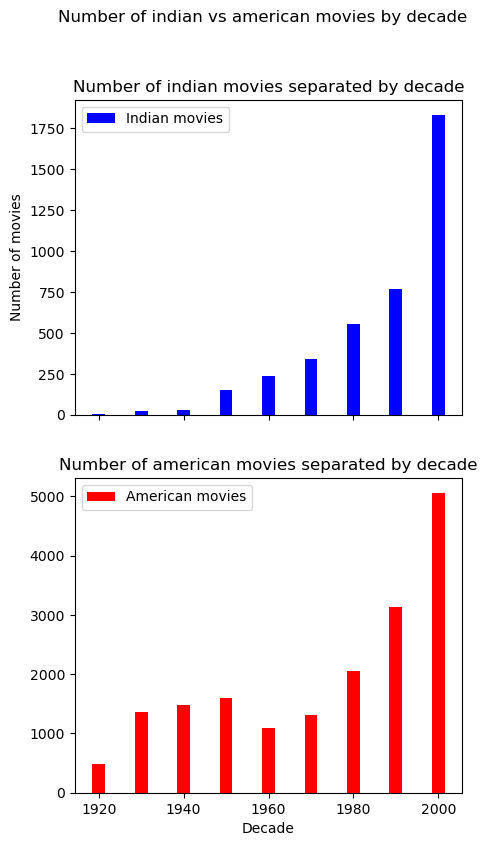

In [277]:
indian_movies = moviedata_filtered[moviedata_filtered.apply(lambda x : 'India' in x.countries, axis = 1)].copy()
american_movies = moviedata_filtered[moviedata_filtered.apply(lambda x : 'United States of America' in x.countries, axis = 1)].copy()

fig, (ax0, ax1) = plt.subplots(nrows=2,figsize=(5, 9), sharex = True)

ax0.bar(indian_movies['decade'].sort_values().unique(), indian_movies.groupby('decade')['movie_name'].count(), 3,label='Indian movies', color = 'blue')
ax1.bar(american_movies['decade'].sort_values().unique(), american_movies.groupby('decade')['movie_name'].count(), 3,label='American movies', color = 'red')
ax0.legend(loc='upper left')
ax1.legend(loc='upper left')


ax0.set_title('Number of indian movies separated by decade')
ax1.set_title('Number of american movies separated by decade')

ax0.set_ylabel('Number of movies')
ax1.set_xlabel('Decade')

fig.suptitle('Number of indian vs american movies by decade')

In [278]:
indian_movies.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
20663735,Narasimham,2000,['India'],"[Action, Musical, Drama, Bollywood]",2000,0,0,1,0,1
8388648,Nee Sneham,2002,['India'],[Drama],2000,2,0,0,0,0
10644072,Bhagwan Dada,1986,['India'],[],1980,6,0,0,0,0
33269085,Kehtaa Hai Dil Baar Baar,2002,"['India', 'United States of America']","[Romance Film, Comedy film]",2000,2,1,0,0,1
2254491,Mr. & Mrs. '55,1955,['India'],"[Musical, Comedy, Bollywood, Romance Film]",1950,5,1,0,0,1


From here we can continue our analysis and compare how women are represented in both geographical with the same metrics used before, for example :
- proportion of women
- average age of female actors
- linguistic analysis of the polts 


First we wish to have a look at the numbers and proportions of male and female characters across all movies :
There are 13976 Indian male characters, corresponding to 65.39% of all characters
There are 7398 Indian female characters, corresponding to 34.61% of all characters
First we wish to have a look at the numbers and proportions of male and female characters across all movies :
There are 94906 American male characters, corresponding to 68.09% of all characters
There are 44475 American female characters, corresponding to 31.91% of all characters


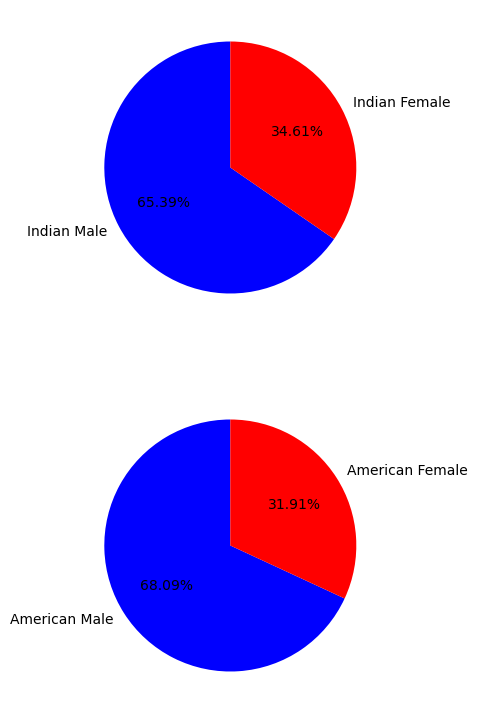

In [279]:
indian_charadata = charadata_filtered[charadata_filtered.index.isin(indian_movies.index)]
american_charadata = charadata_filtered[charadata_filtered.index.isin(american_movies.index)]


#Assess women's presence accross all charaters from every movies
M_ind_count = indian_charadata[indian_charadata.actor_gender == 'M'].shape[0]
F_ind_count = indian_charadata[indian_charadata.actor_gender == 'F'].shape[0]

M_ind_proportion = M_ind_count / (M_ind_count + F_ind_count)
F_ind_proportion = F_ind_count / (M_ind_count + F_ind_count)

M_us_count = american_charadata[american_charadata.actor_gender == 'M'].shape[0]
F_us_count = american_charadata[american_charadata.actor_gender == 'F'].shape[0]

M_us_proportion = M_us_count / (M_us_count + F_us_count)
F_us_proportion = F_us_count / (M_us_count + F_us_count)

print("First we wish to have a look at the numbers and proportions of male and female characters across all movies :")
print("There are {} Indian male characters, corresponding to {:.2f}% of all characters".format(M_ind_count, M_ind_proportion*100))
print("There are {} Indian female characters, corresponding to {:.2f}% of all characters".format(F_ind_count, F_ind_proportion*100))

print("First we wish to have a look at the numbers and proportions of male and female characters across all movies :")
print("There are {} American male characters, corresponding to {:.2f}% of all characters".format(M_us_count, M_us_proportion*100))
print("There are {} American female characters, corresponding to {:.2f}% of all characters".format(F_us_count, F_us_proportion*100))

fig, (ax0, ax1) = plt.subplots(nrows=2,figsize=(5, 9), sharex = True)

ax0.pie([M_ind_proportion, F_ind_proportion], labels = ["Indian Male", "Indian Female"], startangle = 90, autopct = "%0.2f%%",colors=['blue','red'])
ax1.pie([M_us_proportion, F_us_proportion], labels = ["American Male", "American Female"], startangle = 90, autopct = "%0.2f%%",colors=['blue','red'])

plt.show()

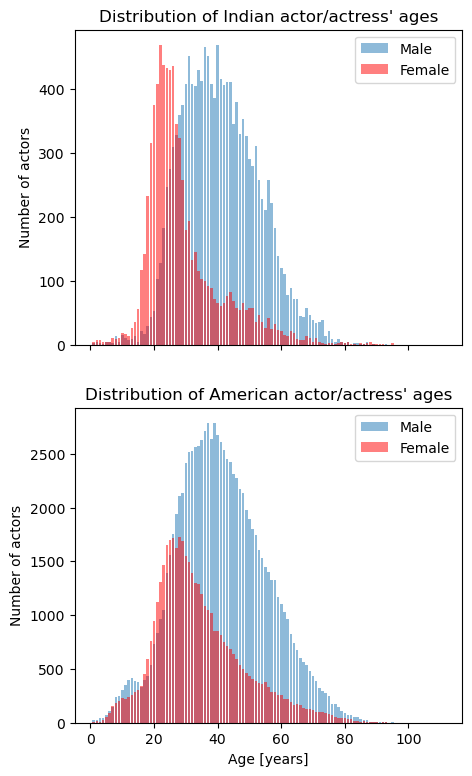

In [280]:
#Plot age distribution across gender

charadata_filtered = charadata_filtered.loc[(charadata_filtered['actor_age']>0) & (charadata_filtered['actor_age']<120)]
indian_charadata = charadata_filtered[charadata_filtered.index.isin(indian_movies.index)]
american_charadata = charadata_filtered[charadata_filtered.index.isin(american_movies.index)]

M_ind = indian_charadata[indian_charadata['actor_gender']=='M']
F_ind = indian_charadata[indian_charadata['actor_gender']=='F']
Mc_ind = M_ind['actor_age'].value_counts()
Fc_ind = F_ind['actor_age'].value_counts()

M_us = american_charadata[american_charadata['actor_gender']=='M']
F_us = american_charadata[american_charadata['actor_gender']=='F']
Mc_us = M_us['actor_age'].value_counts()
Fc_us = F_us['actor_age'].value_counts()

fig, (ax0, ax1) = plt.subplots(nrows=2,figsize=(5, 9), sharex = True)

ax0.bar(np.sort(Mc_ind.index),Mc_ind[np.sort(Mc_ind.index)],alpha=0.5,label='Male')
ax0.bar(np.sort(Fc_ind.index),Fc_ind[np.sort(Fc_ind.index)],alpha=0.5,label='Female', color = 'red')
ax0.set_title("Distribution of Indian actor/actress' ages")
ax0.set_ylabel('Number of actors')
ax0.legend(loc='upper right')

ax1.bar(np.sort(Mc_us.index),Mc_us[np.sort(Mc_us.index)],alpha=0.5,label='Male')
ax1.bar(np.sort(Fc_us.index),Fc_us[np.sort(Fc_us.index)],alpha=0.5,label='Female', color = 'red')
ax1.set_title("Distribution of American actor/actress' ages")
ax1.set_xlabel('Age [years]')
ax1.set_ylabel('Number of actors')
ax1.legend(loc='upper right')

plt.show()

In [281]:
# select 1000 random movies per decade from 1940 to process a langage analysis on the plots
rng = np.random.default_rng(7)

indian_movies.reset_index(inplace=True)
indian_charadata.reset_index(inplace=True)
american_movies.reset_index(inplace=True)
american_charadata.reset_index(inplace=True)


charadata_2_ind = indian_charadata[indian_charadata["character_name"].notna()]

decades = np.arange(1960,2001,10)
sample = []
for decade in decades:
    char_movie = charadata_2_ind[charadata_2_ind['decade'] == decade]
    print(char_movie.wiki_id.nunique())
    sample = np.append(sample, rng.choice(char_movie.wiki_id.unique(), size=170, replace = False))

charadata_2_ind = charadata_2_ind[charadata_2_ind["wiki_id"].isin(sample)]
movie_2_ind = indian_movies[indian_movies["wiki_id"].isin(sample)]
movie_2_ind = movie_2_ind.set_index('wiki_id')
charadata_2_ind = charadata_2_ind.set_index('wiki_id')


charadata_2_us = american_charadata[american_charadata["character_name"].notna()]

sample = []
for decade in decades:
    char_movie = charadata_2_us[charadata_2_us['decade'] == decade]
    sample = np.append(sample, rng.choice(char_movie.wiki_id.unique(), size=170, replace = False))

charadata_2_us = charadata_2_us[charadata_2_us["wiki_id"].isin(sample)]
movie_2_us = american_movies[american_movies["wiki_id"].isin(sample)]
movie_2_us = movie_2_us.set_index('wiki_id')
charadata_2_us = charadata_2_us.set_index('wiki_id')


#Create and initialise colums of the dataframe to count agent verbs, patient verbs and attributes for each character and each movie

charadata_2_ind['agent'] = [[]]*len(charadata_2_ind)
charadata_2_ind['patient'] = [[]]*len(charadata_2_ind)
charadata_2_ind['attributes'] = [[]]*len(charadata_2_ind)


movie_2_ind = movie_2_ind.assign(agent_woman = lambda x : 0)
movie_2_ind = movie_2_ind.assign(patient_woman = lambda x : 0)
movie_2_ind = movie_2_ind.assign(attributes_woman = lambda x : 0)
movie_2_ind = movie_2_ind.assign(agent_man = lambda x : 0)
movie_2_ind = movie_2_ind.assign(patient_man = lambda x : 0)
movie_2_ind = movie_2_ind.assign(attributes_man = lambda x : 0)

charadata_2_ind.reset_index(inplace = True)

extract_xml(movie_2_ind,charadata_2_ind)

#Create and initialise colums of the dataframe to count agent verbs, patient verbs and attributes for each character and each movie

charadata_2_us['agent'] = [[]]*len(charadata_2_us)
charadata_2_us['patient'] = [[]]*len(charadata_2_us)
charadata_2_us['attributes'] = [[]]*len(charadata_2_us)

movie_2_us = movie_2_us.assign(agent_woman = lambda x : 0)
movie_2_us = movie_2_us.assign(patient_woman = lambda x : 0)
movie_2_us = movie_2_us.assign(attributes_woman = lambda x : 0)
movie_2_us = movie_2_us.assign(agent_man = lambda x : 0)
movie_2_us = movie_2_us.assign(patient_man = lambda x : 0)
movie_2_us = movie_2_us.assign(attributes_man = lambda x : 0)


charadata_2_us.reset_index(inplace = True)

extract_xml(movie_2_us,charadata_2_us)

172
266
426
618
1574


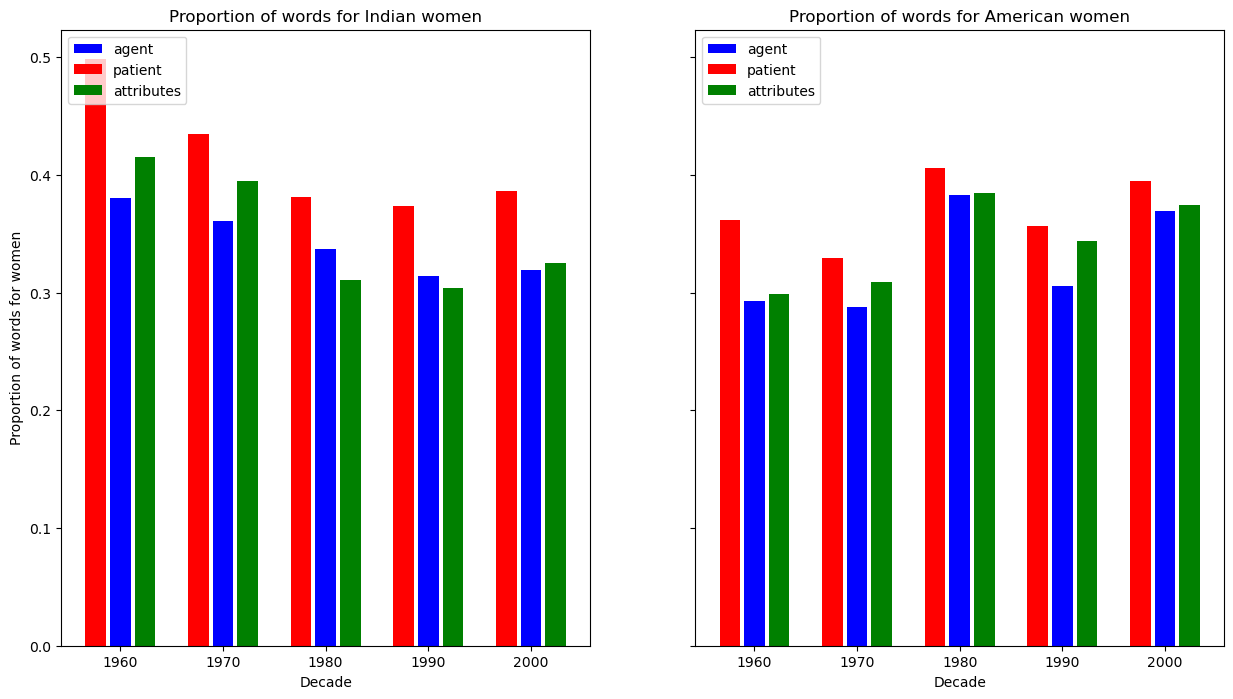

In [282]:
movie_2_ind_grp = movie_2_ind.groupby(['decade'])
agent_mean_ind = movie_2_ind_grp.apply(lambda x : (x['agent_woman']/(x['agent_man'] + x['agent_woman'])).mean())
agent_std_ind = movie_2_ind_grp.apply(lambda x : (x['agent_woman']/(x['agent_man'] + x['agent_woman'])).std())
patient_mean_ind = movie_2_ind_grp.apply(lambda x : (x['patient_woman']/(x['patient_man'] + x['patient_woman'])).mean())
patient_std_ind = movie_2_ind_grp.apply(lambda x : (x['patient_woman']/(x['patient_man'] + x['patient_woman'])).std())
attributes_mean_ind = movie_2_ind_grp.apply(lambda x : (x['attributes_woman']/(x['attributes_man'] + x['attributes_woman'])).mean())
attributes_std_ind = movie_2_ind_grp.apply(lambda x : (x['attributes_woman']/(x['attributes_man'] + x['attributes_woman'])).std())


movie_2_us_grp = movie_2_us.groupby(['decade'])
agent_mean_us = movie_2_us_grp.apply(lambda x : (x['agent_woman']/(x['agent_man'] + x['agent_woman'])).mean())
agent_std_us = movie_2_us_grp.apply(lambda x : (x['agent_woman']/(x['agent_man'] + x['agent_woman'])).std())
patient_mean_us = movie_2_us_grp.apply(lambda x : (x['patient_woman']/(x['patient_man'] + x['patient_woman'])).mean())
patient_std_us = movie_2_us_grp.apply(lambda x : (x['patient_woman']/(x['patient_man'] + x['patient_woman'])).std())
attributes_mean_us = movie_2_us_grp.apply(lambda x : (x['attributes_woman']/(x['attributes_man'] + x['attributes_woman'])).mean())
attributes_std_us = movie_2_us_grp.apply(lambda x : (x['attributes_woman']/(x['attributes_man'] + x['attributes_woman'])).std())


fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(15, 8), sharey = True)

ax0.bar(agent_mean_ind.index, agent_mean_ind,width/1.5,label='agent', color = 'blue')
ax0.bar(patient_mean_ind.index - width/1.25, patient_mean_ind,width/1.5,  label='patient', color = 'red')
ax0.bar(attributes_mean_ind.index + width/1.25, attributes_mean_ind,width/1.5,  label='attributes', color = 'green')
ax0.set_title("Proportion of words for Indian women")

ax1.bar(agent_mean_us.index, agent_mean_us,width/1.5,label='agent', color = 'blue')
ax1.bar(patient_mean_us.index - width/1.25, patient_mean_us,width/1.5,  label='patient', color = 'red')
ax1.bar(attributes_mean_us.index + width/1.25, attributes_mean_us,width/1.5,  label='attributes', color = 'green')
ax1.set_title("Proportion of words for American women")

ax0.legend(loc = 'upper left')
ax0.set_xlabel('Decade')
ax0.set_ylabel('Proportion of words for women')

ax1.legend(loc = 'upper left')
ax1.set_xlabel('Decade')
plt.show()

### Wordcloud India vs US

In [283]:
#Create the dataframe that will contain the list of word for each type, for each decade, and for each gender

list_word_ind = pd.DataFrame()
list_word_ind['agent'] = charadata_2_ind.groupby(['decade', 'actor_gender'])['agent'].agg(sum)
list_word_ind['patient'] = charadata_2_ind.groupby(['decade', 'actor_gender'])['patient'].agg(sum)
list_word_ind['attribute'] = charadata_2_ind.groupby(['decade', 'actor_gender'])['attributes'].agg(sum)

list_word_us = pd.DataFrame()
list_word_us['agent'] = charadata_2_us.groupby(['decade', 'actor_gender'])['agent'].agg(sum)
list_word_us['patient'] = charadata_2_us.groupby(['decade', 'actor_gender'])['patient'].agg(sum)
list_word_us['attribute'] = charadata_2_us.groupby(['decade', 'actor_gender'])['attributes'].agg(sum)

In [284]:
#INDIA

decade = [1960, 1970, 1980, 1990, 2000]
gender = ['F','M']
type = ['agent', 'patient', 'attribute' ]

for dec in decade:
    for gen in gender:

        #Select the mask 
        if gen == 'F':
            mask = woman_mask
        else:
            mask = man_mask
        
        for ty in type:

            # Create a string from each word in the list
            text = " ".join(str(word) for word in list_word_ind.loc[dec,gen][ty])

            # Casefolding
            text = text.lower() 

            # Creating a spacy object for lemmatization
            nlp = spacy.load('en_core_web_sm')
            text_sp = nlp(text)

            # Lemmatization
            words = []
            words = words + [token.lemma_ for token in text_sp]

            # Create a string from each lemmatized word in the list
            text_wordcloud = ' '.join(word for word in words)

            # Generate Wordcloud
            wc = WordCloud(color_func=lambda *args, **kwargs: "red", background_color="white", max_words=100, mask=mask,
                    stopwords=STOPWORDS, max_font_size=40, random_state=1,height=100,width=100,collocations=False).generate(text_wordcloud)

            # store to file
            wc.to_file(path.join("WordCloud/India_vs_US/India", f"{dec}_"+f"{gen}_"+f"{ty}.png"))     

            

In [285]:
#INDIA

for gen in gender:

    if gen == 'F':
        mask = woman_mask
    else:
        mask = man_mask
    
    for ty in type:

        # Create a string from each word in the list for the entire era
        text = " ".join(str(word) for word in list_word_ind.loc[1960,gen][ty] + list_word_ind.loc[1970,gen][ty] + list_word_ind.loc[1980,gen][ty] + list_word_ind.loc[1990,gen][ty] + list_word_ind.loc[2000,gen][ty])
        # Casefolding
        text = text.lower() 

        # Creating a spacy object for lemmatization
        nlp = spacy.load('en_core_web_sm')
        text_sp = nlp(text)

        # Lemmatization
        # removing stop words and lematize
        words = []
        words = words + [token.lemma_ for token in text_sp]

        text_wordcloud = ' '.join(word for word in words)

        # Generate Wordcloud
        wc = WordCloud(color_func=lambda *args, **kwargs: "red", background_color="white", max_words=100, mask=mask,
                stopwords=STOPWORDS, max_font_size=40, random_state=1,height=100,width=100,collocations=False).generate(text_wordcloud)

        # store to file
        wc.to_file(path.join("WordCloud/India_vs_US/India", "Full_"+f"{gen}_"+f"{ty}.png")) 

In [286]:
#US

decade = [1960, 1970, 1980, 1990, 2000]
gender = ['F','M']
type = ['agent', 'patient', 'attribute' ]

for dec in decade:
    for gen in gender:

        if gen == 'F':
            mask = woman_mask
        else:
            mask = man_mask
        
        for ty in type:

            text = " ".join(str(word) for word in list_word_us.loc[dec,gen][ty])
            # Casefolding
            text = text.lower() 

            # Creating a spacy object for lemmatization
            nlp = spacy.load('en_core_web_sm')
            text_sp = nlp(text)

            # Lemmatization
            # removing stop words and lematize
            words = []
            words = words + [token.lemma_ for token in text_sp]

            text_wordcloud = ' '.join(word for word in words)

            # Generate Wordcloud
            wc = WordCloud(color_func=lambda *args, **kwargs: "red", background_color="white", max_words=100, mask=mask,
                    stopwords=STOPWORDS, max_font_size=40, random_state=1,height=100,width=100,collocations=False).generate(text_wordcloud)

            # store to file
            wc.to_file(path.join("WordCloud/India_vs_US/US", f"{dec}_"+f"{gen}_"+f"{ty}.png"))     

            

In [287]:
#US

for gen in gender:

    if gen == 'F':
        mask = woman_mask
    else:
        mask = man_mask
    
    for ty in type:

        text = " ".join(str(word) for word in list_word_us.loc[1960,gen][ty] + list_word_us.loc[1970,gen][ty] + list_word_us.loc[1980,gen][ty] + list_word_us.loc[1990,gen][ty] + list_word_us.loc[2000,gen][ty])
        # Casefolding
        text = text.lower() 

        # Creating a spacy object for lemmatization
        nlp = spacy.load('en_core_web_sm')
        text_sp = nlp(text)

        # Lemmatization
        # removing stop words and lematize
        words = []
        words = words + [token.lemma_ for token in text_sp]

        text_wordcloud = ' '.join(word for word in words)

        # Generate Wordcloud
        wc = WordCloud(color_func=lambda *args, **kwargs: "red", background_color="white", max_words=100, mask=mask,
                stopwords=STOPWORDS, max_font_size=40, random_state=1,height=100,width=100,collocations=False).generate(text_wordcloud)

        # store to file
        wc.to_file(path.join("WordCloud/India_vs_US/US", "Full_"+f"{gen}_"+f"{ty}.png")) 

### Additional dataset: population's reception to women-empowering movies

Metacritic website gathers critiques given by professional movie critics and computes them into a `metascore`. We can use this metascore to assess how movies with important and active main female characters were received by the society at the time the movie aired.

In [288]:
# Get metascore from already parsed metascore website
url = "https://raw.githubusercontent.com/miazhx/metacritic/master/data/metacritic_movies.csv"
metascore = pd.read_csv(url)
metascore.head()

,movie_title,release_date,genre,meta_mixed,meta_negative,meta_positive,metascore,user_mixed,user_negative,user_positive,userscore
0,Anatomy of a Murder,1-Jul-59,"Drama,Mystery,Thriller,Crime",0,0,15,95,0,0,3,tbd
1,Bringing Up Baby,18-Feb-38,"Comedy,Romance,Family",0,1,16,91,1,0,2,tbd
2,After Life,12-May-99,"Drama,Fantasy",0,0,19,91,0,2,1,tbd
3,Gavagai,3-Aug-18,Drama,1,0,6,91,0,1,2,tbd
4,The Hustler,25-Sep-61,"Drama,Sport",1,0,17,90,0,0,3,tbd


In [289]:
metascore.release_date = pd.to_datetime(metascore.release_date.astype(str), errors = 'coerce')
metascore['year'] = pd.DatetimeIndex(metascore['release_date']).year

In [290]:
metascore.year = metascore['year'].apply(lambda x : x - 100 if x > 2013 else x)

In [291]:
# We keep movies for which we have a metascore
metascore.movie_title = metascore.movie_title.str.lower()
moviedata_filtered.movie_name = moviedata_filtered.movie_name.str.lower()

metascore_filtered = metascore[metascore["movie_title"].isin(moviedata_filtered.movie_name)]
print("We have {} movies which have a metascore.".format(len(metascore_filtered)))

We have 4374 movies which have a metascore.


In [292]:
metascore_filtered.head()

,movie_title,release_date,genre,meta_mixed,meta_negative,meta_positive,metascore,user_mixed,user_negative,user_positive,userscore,year
0,anatomy of a murder,2059-07-01,"Drama,Mystery,Thriller,Crime",0,0,15,95,0,0,3,tbd,1959
1,bringing up baby,2038-02-18,"Comedy,Romance,Family",0,1,16,91,1,0,2,tbd,1938
2,after life,1999-05-12,"Drama,Fantasy",0,0,19,91,0,2,1,tbd,1999
4,the hustler,2061-09-25,"Drama,Sport",1,0,17,90,0,0,3,tbd,1961
5,the circus,2029-01-01,"Comedy,Romance",0,0,7,90,0,0,3,tbd,1929


We have a quite high number of movies with a metascore we can proceed to further analysis 

In [293]:
moviedata_score = moviedata_filtered.reset_index().merge(metascore_filtered, suffixes=('', '_2'), how="inner", left_on=["movie_name","release"], right_on=["movie_title","year"]).set_index('wiki_id')#.drop(columns= ["WikiQID"])
len(moviedata_score)

3141

In [294]:
moviedata_score.head(2)

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre,...,genre,meta_mixed,meta_negative,meta_positive,metascore,user_mixed,user_negative,user_positive,userscore,year_2
wiki_id,,,,,,,,,,,,,,,,,,,,,
1952976,dark water,2005,['United States of America'],"[Drama, Thriller, Horror]",2000,5,0,0,1,1,...,"Drama,Thriller,Horror",15,5,15,52,23,14,158,8.7,2005
12978934,the deep end of the ocean,1999,['United States of America'],"[Film adaptation, Family Drama, Drama, Family ...",1990,9,0,0,0,0,...,Drama,16,5,7,45,3,2,10,6.9,1999


In [295]:
moviedata_filtered[moviedata_filtered.movie_name.isin(moviedata_filtered[moviedata_filtered.duplicated(['movie_name','release'])].movie_name) & moviedata_filtered.release.isin(moviedata_filtered[moviedata_filtered.duplicated(['movie_name','release'])].release)].sort_values('movie_name')

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
12864134,angel,2007,['Puerto Rico'],[Drama],2000,7,0,0,0,0
14969658,angel,2007,"['United Kingdom', 'France', 'Belgium']","[Period piece, Film adaptation, Parody, Romant...",2000,7,1,0,0,1
25080803,bad karma,2002,['United States of America'],"[Psychological thriller, Slasher, Thriller, Ho...",2000,2,0,0,1,1
25489035,bad karma,2002,['United Kingdom'],"[Short Film, Splatter film]",2000,2,0,0,0,0
3529964,black rain,1989,['United States of America'],"[Action, Suspense, Crime Fiction, Action/Adven...",1980,9,0,1,0,1
3608663,black rain,1989,['Japan'],"[Japanese Movies, World cinema, War film, Drama]",1980,9,0,0,0,0
21356182,buried alive,2007,[],"[Supernatural, Horror]",2000,7,0,0,1,1
11600310,buried alive,1990,"['United States of America', 'South Africa']","[Indie, Horror]",1990,0,0,0,1,1
36036213,buried alive,1990,['United States of America'],"[Thriller, Horror]",1990,0,0,0,1,1


In [296]:
charadata_score = charadata_filtered.loc[moviedata_score.index.unique()]
movie_score = moviedata_filtered.loc[moviedata_score.index.unique()]

#Create and initialise colums of the dataframe to count agent verbs, patient verbs and attributes for each character and each movie

charadata_score['agent'] = [[]]*len(charadata_score)
charadata_score['patient'] = [[]]*len(charadata_score)
charadata_score['attributes'] = [[]]*len(charadata_score)


movie_score = movie_score.assign(agent_woman = lambda x : 0)
movie_score = movie_score.assign(patient_woman = lambda x : 0)
movie_score = movie_score.assign(attributes_woman = lambda x : 0)
movie_score = movie_score.assign(agent_man = lambda x : 0)
movie_score = movie_score.assign(patient_man = lambda x : 0)
movie_score = movie_score.assign(attributes_man = lambda x : 0)

charadata_score.reset_index(inplace = True)
charadata_score.head()

,wiki_id,release,character_name,actor_gender,actor_name,actor_age,decade,agent,patient,attributes
0,1952976,2005,Mediator,F,Linda Emond,46.0,2000,[],[],[]
1,1952976,2005,Dahlia,F,Jennifer Connelly,34.0,2000,[],[],[]
2,1952976,2005,Mr. Murray,M,John C. Reilly,40.0,2000,[],[],[]
3,1952976,2005,Jeff Platzer,M,Tim Roth,44.0,2000,[],[],[]
4,1952976,2005,Kyle Williams,M,Dougray Scott,39.0,2000,[],[],[]


In [297]:
extract_xml(movie_score,charadata_score)
charadata_score.tail()

,wiki_id,release,character_name,actor_gender,actor_name,actor_age,decade,agent,patient,attributes
39639,277160,1999,Haas,M,Kevin McNally,43.0,1990,[],[],[]
39640,277160,1999,Conrad Greene,M,Maury Chaykin,49.0,1990,[],[],[]
39641,277160,1999,Robert MacDougall,M,Sean Connery,68.0,1990,[],[],[MacDougal]
39642,277160,1999,Virginia Baker,F,Catherine Zeta-Jones,29.0,1990,[investigator],[],"[investigator, Baker]"
39643,277160,1999,Aaron Thibadeaux,M,Ving Rhames,39.0,1990,[],[],[]


In [298]:
movie_score['ratio_agent'] = movie_score.agent_woman / (movie_score.agent_woman + movie_score.agent_man)
movie_score['ratio_patient'] = movie_score.patient_woman / (movie_score.patient_woman + movie_score.patient_man)
movie_score['ratio_attributes'] = movie_score.attributes_woman / (movie_score.attributes_woman + movie_score.attributes_man)
movie_score.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre,agent_woman,patient_woman,attributes_woman,agent_man,patient_man,attributes_man,ratio_agent,ratio_patient,ratio_attributes
wiki_id,,,,,,,,,,,,,,,,,,,
1952976,dark water,2005,['United States of America'],"[Drama, Thriller, Horror]",2000,5,0,0,1,1,21,6,26,9,7,13,0.700000,0.461538,0.666667
12978934,the deep end of the ocean,1999,['United States of America'],"[Film adaptation, Family Drama, Drama, Family ...",1990,9,0,0,0,0,4,2,7,19,15,24,0.173913,0.117647,0.225806
5425205,eastern promises,2007,"['United Kingdom', 'United States of America',...","[Crime Fiction, Mystery, Thriller, Crime Thril...",2000,7,0,0,0,0,9,3,13,25,5,28,0.264706,0.375000,0.317073
529276,jaws: the revenge,1987,['United States of America'],"[Action, Action/Adventure, Thriller, Horror, N...",1980,7,0,1,1,2,10,8,22,20,16,26,0.333333,0.333333,0.458333
226664,about schmidt,2002,['United States of America'],"[Drama, Indie, Comedy, Comedy of manners, Blac...",2000,2,0,0,0,0,36,12,42,19,5,24,0.654545,0.705882,0.636364


In [299]:
movie_score = movie_score.reset_index().merge(metascore_filtered, suffixes=('', '_2'), how="inner", left_on=["movie_name","release"], right_on=["movie_title","year"]).set_index('wiki_id')

In [300]:
movie_score.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre,...,genre,meta_mixed,meta_negative,meta_positive,metascore,user_mixed,user_negative,user_positive,userscore,year_2
wiki_id,,,,,,,,,,,,,,,,,,,,,
1952976,dark water,2005,['United States of America'],"[Drama, Thriller, Horror]",2000,5,0,0,1,1,...,"Drama,Thriller,Horror",15,5,15,52,23,14,158,8.7,2005
12978934,the deep end of the ocean,1999,['United States of America'],"[Film adaptation, Family Drama, Drama, Family ...",1990,9,0,0,0,0,...,Drama,16,5,7,45,3,2,10,6.9,1999
5425205,eastern promises,2007,"['United Kingdom', 'United States of America',...","[Crime Fiction, Mystery, Thriller, Crime Thril...",2000,7,0,0,0,0,...,"Drama,Mystery,Thriller,Crime",3,0,32,82,26,51,221,7,2007
529276,jaws: the revenge,1987,['United States of America'],"[Action, Action/Adventure, Thriller, Horror, N...",1980,7,0,1,1,2,...,"Adventure,Thriller,Horror",1,14,0,15,4,28,3,2.1,1987
226664,about schmidt,2002,['United States of America'],"[Drama, Indie, Comedy, Comedy of manners, Blac...",2000,2,0,0,0,0,...,"Drama,Comedy",6,0,34,85,19,13,100,7.5,2002


<AxesSubplot:xlabel='ratio_agent', ylabel='metascore'>

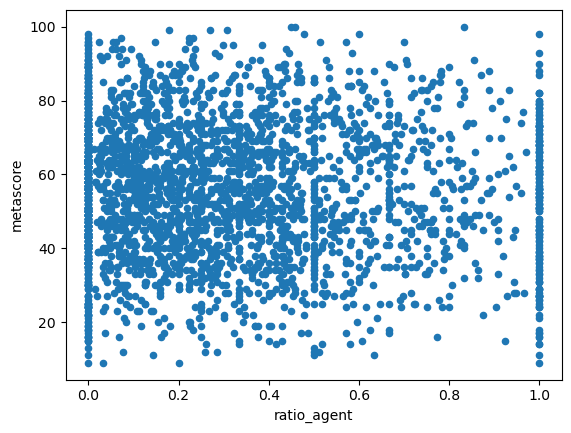

In [301]:
movie_score.plot('ratio_agent','metascore',kind = 'scatter')

<AxesSubplot:xlabel='ratio_patient', ylabel='metascore'>

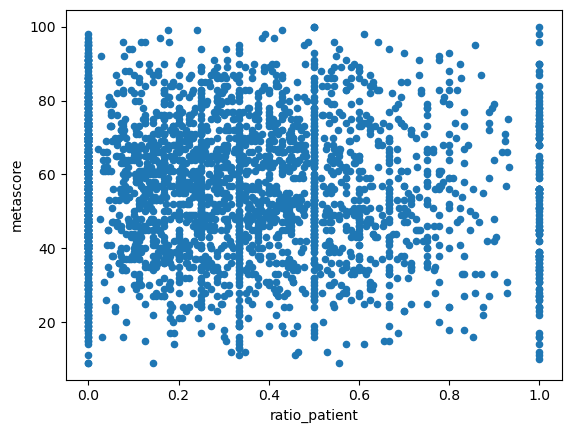

In [302]:
movie_score.plot('ratio_patient','metascore',kind = 'scatter')

<AxesSubplot:xlabel='ratio_attributes', ylabel='metascore'>

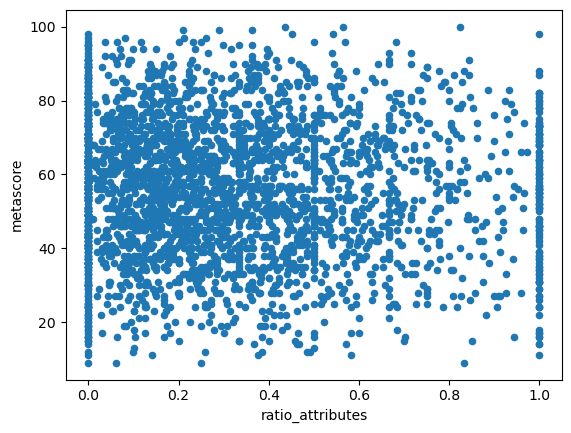

In [303]:
movie_score.plot('ratio_attributes','metascore',kind = 'scatter')

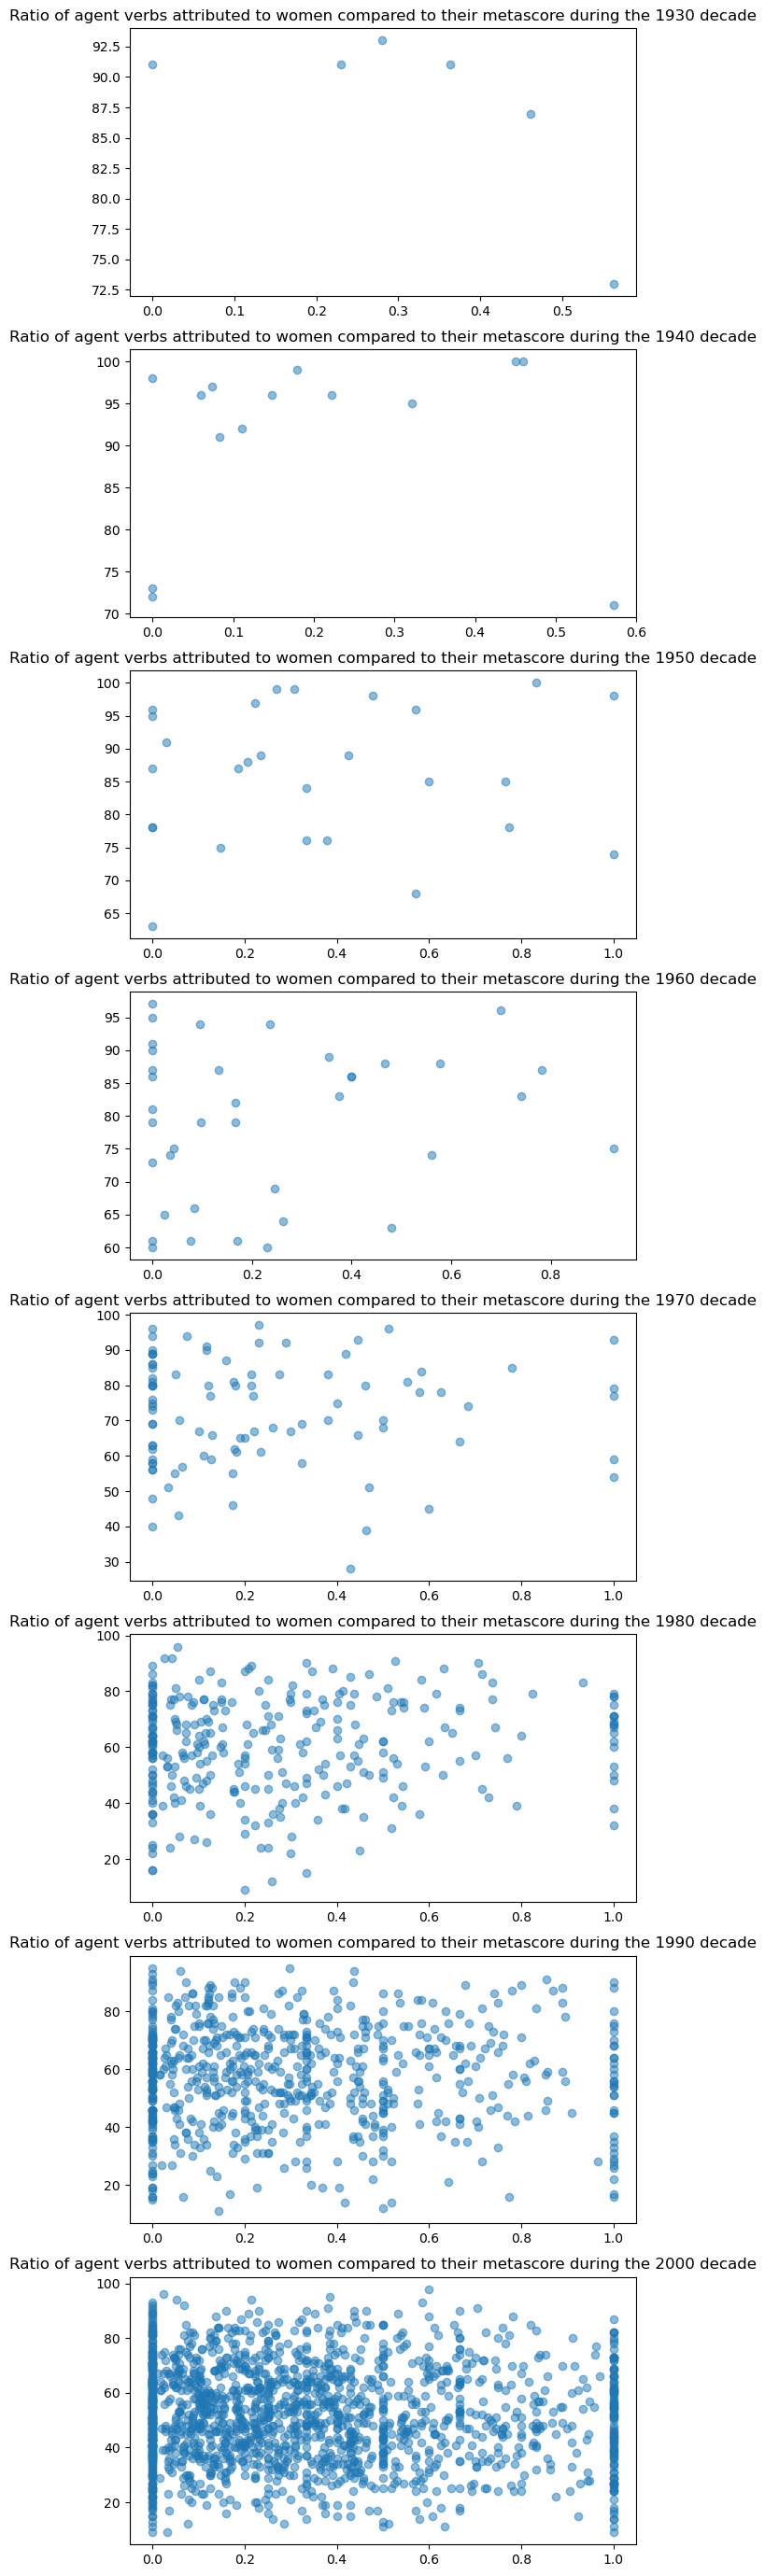

In [304]:
fig,axs=plt.subplots(movie_score['decade'].nunique(),1,figsize=(7, 35))

decades=np.sort(movie_score['decade'].unique())

for i, decade in enumerate(decades) : 
    M = movie_score[movie_score['decade']==decade]
   
    axs[i].scatter(M.ratio_agent, M.metascore, alpha=0.5,label='ratio_agent')
    axs[i].set_title(f"Ratio of agent verbs attributed to women compared to their metascore during the {decade} decade")


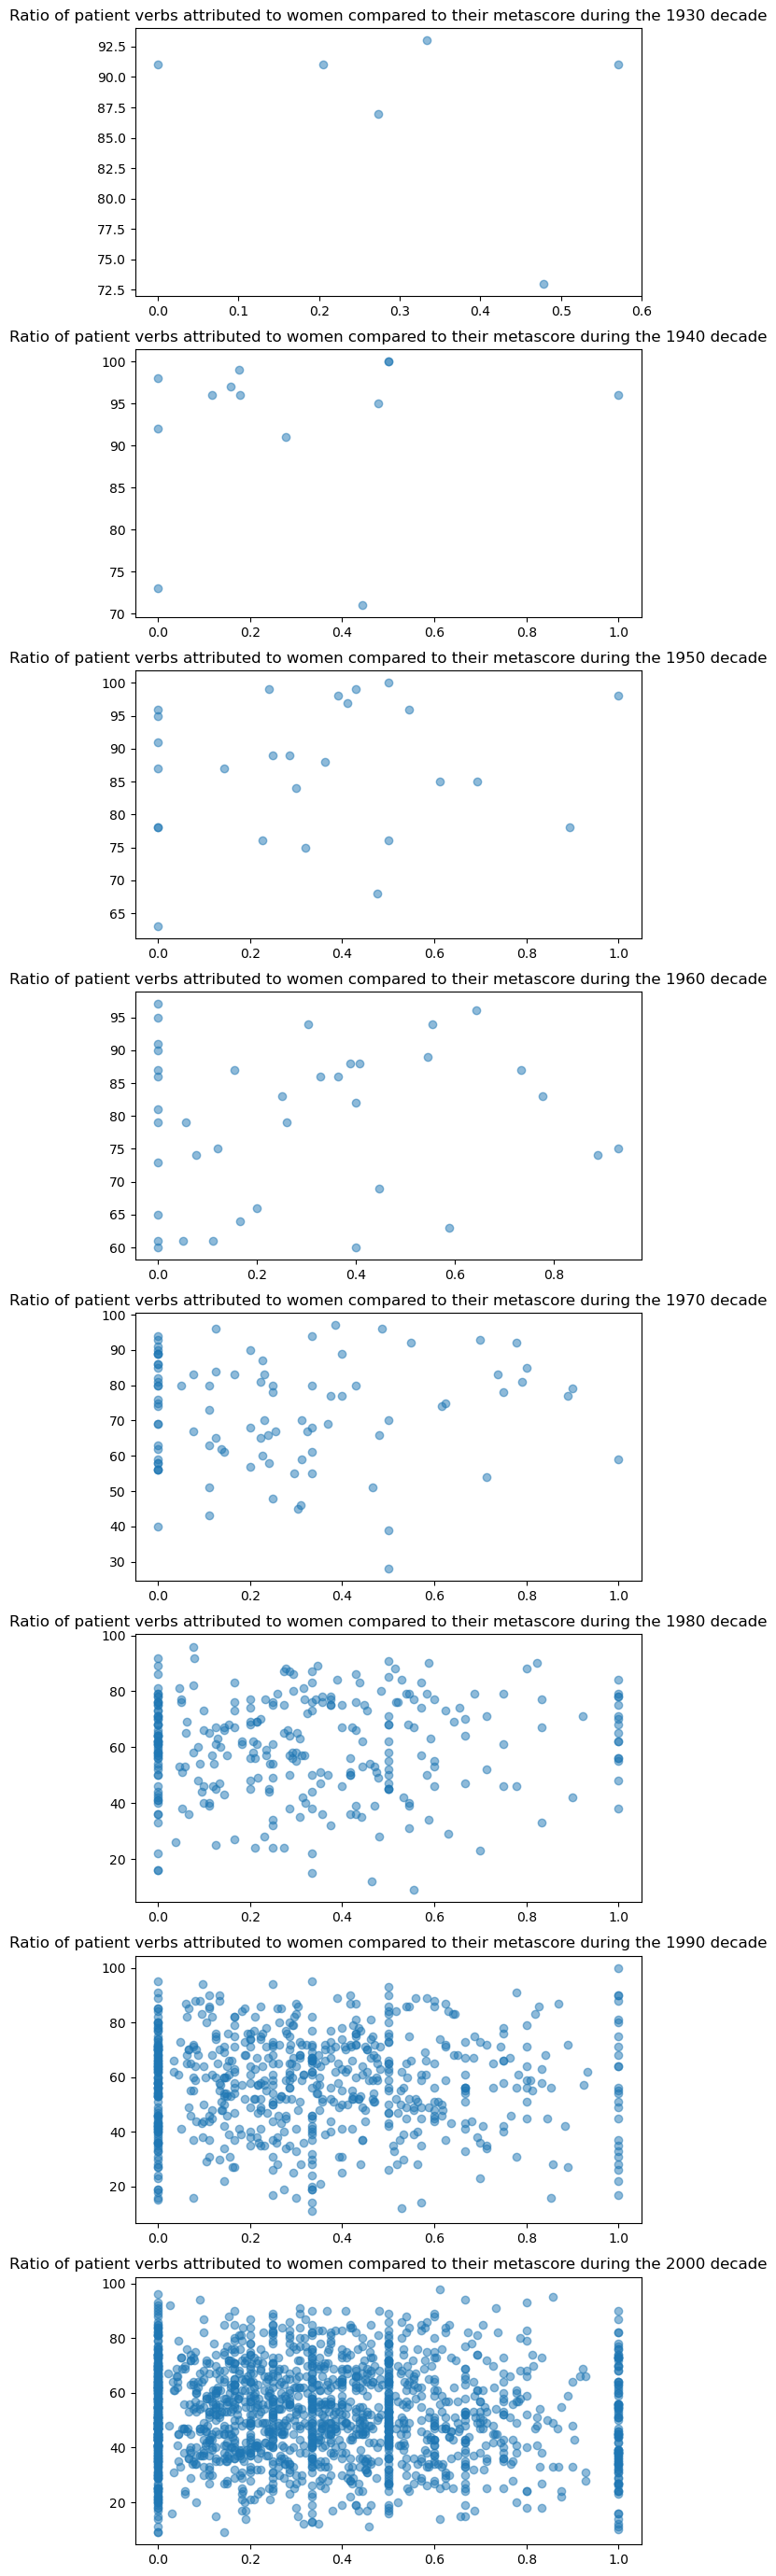

In [305]:
fig,axs=plt.subplots(movie_score['decade'].nunique(),1,figsize=(7, 35))

decades=np.sort(movie_score['decade'].unique())

for i, decade in enumerate(decades) : 
    M = movie_score[movie_score['decade']==decade]
   
    axs[i].scatter(M.ratio_patient, M.metascore, alpha=0.5,label='ratio_patient')
    axs[i].set_title(f"Ratio of patient verbs attributed to women compared to their metascore during the {decade} decade")


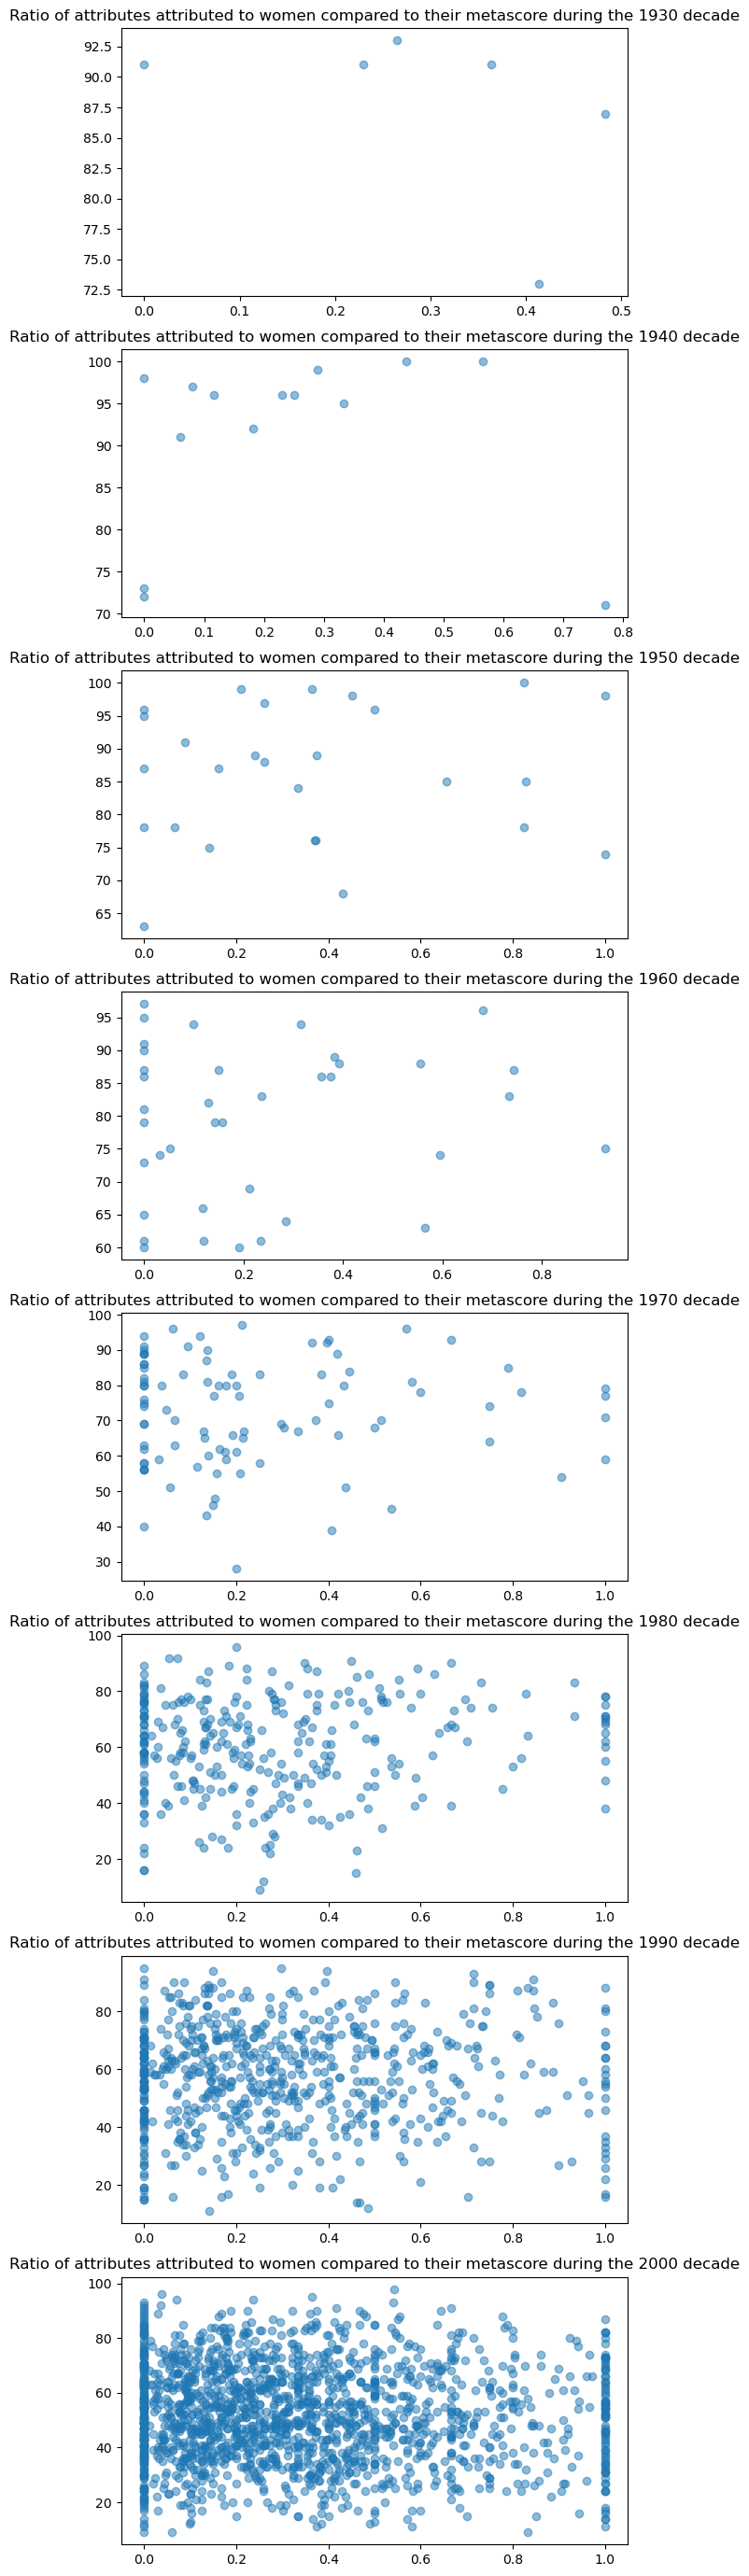

In [306]:
fig,axs=plt.subplots(movie_score['decade'].nunique(),1,figsize=(7, 35))

decades=np.sort(movie_score['decade'].unique())

for i, decade in enumerate(decades) : 
    M = movie_score[movie_score['decade']==decade]
   
    axs[i].scatter(M.ratio_attributes, M.metascore, alpha=0.5,label='ratio_attributes')
    axs[i].set_title(f"Ratio of attributes attributed to women compared to their metascore during the {decade} decade")